<a href="https://colab.research.google.com/github/AlirezaGhavidel70/AI-based-bridge-network-analysis/blob/main/Bridge_Network_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### user inputs for analysis  #####
import sympy
from sympy import *
import torch.nn as nn
import pandas as pd
import numpy as np

years = 30 # planning horizon
num_statistic = 1 # number of episodes
times =[0,10,25]
budget_ratio = 0.010  # budget ration for each year to multiply the total amount of construction (all bridges in the network)
cumulative_budget = True # if you want to use the remained budget from the previous year to the next year please put "True", otherwise the remained budget is not transferr to the next year "False"
workforce_ratio = 0.1   #This ratio restricts the number of bridges that can be maintained each year within the total bridge network.
### Bridge parameters ##########

C_b = 160.19 # Bridge construction cost rate $/ft2 deck area
# units in the excel file: Deck area = square meter, Ld (detour length) = km
file_path = '/content/drive/MyDrive/bridge_parameters.xlsx'  # Replace with your file's path
sheet_name = 'Sheet1'  # Replace with your sheet name if needed
x= Symbol('x')
y2= 11.8246*sympy.exp(56.1606*((sympy.log(x/134.7200))**-1)) # it is for Memphis (you can put the seismic hazard curve)



In [ ]:

# Read the Excel file into a DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)
deck_area_Net= df['deck_area'].to_numpy()
L_d_Net = df['Detour_length'].to_numpy()
ADT_Net = df['ADT'].to_numpy()
r_Truck_Net = df['Truck_ratio'].to_numpy()
columns_to_read = ['CR deck', 'CR super', 'CR sub']  # Specify the column letters
df_initial = pd.read_excel(file_path, usecols=columns_to_read)
# Convert the DataFrame into the desired array format
initial_state = df_initial.to_numpy().tolist()
initial_state = np.asarray(initial_state)-1
Centrality = df['Centrality'].to_numpy()
start_x = df['Start_x'].to_numpy()
start_y = df['Start y'].to_numpy()
C_b = C_b * 10.764   # convert to $/m2

In [ ]:
### call the required packages from library #####
!pip install contextily
import math
from copy import deepcopy
from sklearn import preprocessing
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np
from operator import itemgetter
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from shapely.geometry import Point
import time
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import matplotlib.pyplot as plt
from copy import deepcopy

import scipy
import sympy
from scipy import special
from sympy import *
from scipy.misc import derivative
from scipy import *
from scipy.stats import lognorm
from scipy.optimize import minimize, rosen, rosen_der
from scipy import special
from scipy.stats import norm

import folium
from folium.plugins import MarkerCluster
import geopandas as gpd


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 50.6 MB/s eta 0:00:00


In [ ]:
# -*- coding: utf-8 -*-

# Fragility models and risk assessment

class FRAG_DRL:

    def __init__(self, time_t=[], jacket_time=[], extender_time=[], shearKey_time=[], RC_time=[], EB_time=[]):


        self.time_t=np.array(time_t)
        self.extender_time=np.array(extender_time)
        self.jacket_time= np.array(jacket_time)
        self.shearKey_time= np.array(shearKey_time)
        self.RC_time= np.array(RC_time)
        self.EB_time= np.array(EB_time)


    def mod_frag(pf,x,mod_factors):

        f = lambda x,mu,sigma: scipy.stats.lognorm.cdf(x, sigma, loc=0, scale=np.exp(mu))
        #x0 = np.asarray([np.log(1.5), 0.5])
        x0 = np.asarray([np.log(1.5), 0.001])
        mu,sigma = scipy.optimize.curve_fit(f,x,pf,p0=x0,method='lm',maxfev=5000)[0]
        mu=np.log(np.exp(mu)*mod_factors[0])
        sigma=sigma*mod_factors[1]
        pf_mod = scipy.stats.lognorm.cdf(x, sigma, loc=0, scale=np.exp(mu))
        return pf_mod, mu,sigma


    def fraglity (self,):

        frag_mod_factors_SJ= [1.03,1,1.16,1,1.17,1,1.20,1]
        frag_mod_factors_EB= [2.94,1,1.31,1,1.21,1,1.17,1]
        frag_mod_factors_RC= [1.04,1,0.96,1,1.01,1,1.05,1]
        frag_mod_factors_SE= [1.01,1,1.00,1,1.00,1,1.31,1]
        frag_mod_factors_SK= [1.01,1,0.98,1,0.99,1,1.01,1]
        frag_mod_factors_RC_SK= [1.04,1,0.96,1,1.04,1,1.12,1]
        frag_mod_factors_SE_SK= [1.01,1,0.97,1,0.99,1,1.37,1]
        frag_mod_factors_SJ_SE= [1.03,1,1.16,1,1.17,1,1.31,1]
        frag_mod_factors_SJ_SK= [1.03,1,1.16,1,1.17,1,1.37,1]
        frag_mod_factors_SJ_SE_SK=[1.03,1,1.16,1,1.17,1,1.37,1]



        PGA=np.linspace(np.log(0.01), np.log(3), 30)
        PGA=np.exp(PGA)
        size=PGA.size



        lam_factor_complete_sys= np.zeros(size)
        lam_factor_extensive_sys= np.zeros(size)
        lam_factor_moderate_sys= np.zeros(size)
        lam_factor_slight_sys= np.zeros(size)




        P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21))/0.69)
        P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61))/0.60)
        P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86))/0.60)
        P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20))/0.61)





        x= Symbol('x')
        #y2= 11.8246*sympy.exp(56.1606*((sympy.log(x/134.7200))**-1)) # it is for Memphis (you can put the seismic hazard curve)
        y2prime=y2.diff(x)
        yprime=y2prime
        f = lambdify(x, yprime, 'numpy')

        s=np.zeros(size)
        s1 = np.zeros(size)



        lam_factor_complete_sys= np.zeros(size)
        lam_factor_extensive_sys= np.zeros(size)
        lam_factor_moderate_sys= np.zeros(size)
        lam_factor_slight_sys= np.zeros(size)



        for sa in range (0,size):
            s[sa]=np.abs(f(PGA[sa]))
            if sa!=0:
                s1[sa]=s[sa]*np.abs((PGA[sa]-PGA[sa-1]))


        if self.time_t>=self.extender_time and self.time_t>=self.jacket_time and self.time_t>=self.shearKey_time:


            #print('three')

            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_SJ_SE_SK[0]))/(0.69*frag_mod_factors_SJ_SE_SK[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_SJ_SE_SK[2]))/(0.60*frag_mod_factors_SJ_SE_SK[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_SJ_SE_SK[4]))/(0.60*frag_mod_factors_SJ_SE_SK[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_SJ_SE_SK[6]))/(0.61*frag_mod_factors_SJ_SE_SK[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys

        elif self.time_t>=self.extender_time and self.time_t>=self.jacket_time:


            #print('three')

            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_SJ_SE[0]))/(0.69*frag_mod_factors_SJ_SE[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_SJ_SE[2]))/(0.60*frag_mod_factors_SJ_SE[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_SJ_SE[4]))/(0.60*frag_mod_factors_SJ_SE[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_SJ_SE[6]))/(0.61*frag_mod_factors_SJ_SE[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys

        elif self.time_t>=self.shearKey_time and self.time_t>=self.jacket_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_SJ_SK[0]))/(0.69*frag_mod_factors_SJ_SK[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_SJ_SK[2]))/(0.60*frag_mod_factors_SJ_SK[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_SJ_SK[4]))/(0.60*frag_mod_factors_SJ_SK[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_SJ_SK[6]))/(0.61*frag_mod_factors_SJ_SK[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys
        elif self.time_t>=self.extender_time and self.time_t>=self.shearKey_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_SE_SK[0]))/(0.69*frag_mod_factors_SE_SK[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_SE_SK[2]))/(0.60*frag_mod_factors_SE_SK[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_SE_SK[4]))/(0.60*frag_mod_factors_SE_SK[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_SE_SK[6]))/(0.61*frag_mod_factors_SE_SK[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys

        elif self.time_t>=self.RC_time and self.time_t>=self.shearKey_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_RC_SK[0]))/(0.69*frag_mod_factors_RC_SK[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_RC_SK[2]))/(0.60*frag_mod_factors_RC_SK[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_RC_SK[4]))/(0.60*frag_mod_factors_RC_SK[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_RC_SK[6]))/(0.61*frag_mod_factors_RC_SK[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys

        elif self.time_t>=self.shearKey_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_SK[0]))/(0.69*frag_mod_factors_SK[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_SK[2]))/(0.60*frag_mod_factors_SK[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_SK[4]))/(0.60*frag_mod_factors_SK[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_SK[6]))/(0.61*frag_mod_factors_SK[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys


        elif self.time_t>=self.extender_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_SE[0]))/(0.69*frag_mod_factors_SE[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_SE[2]))/(0.60*frag_mod_factors_SE[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_SE[4]))/(0.60*frag_mod_factors_SE[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_SE[6]))/(0.61*frag_mod_factors_SE[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys

        elif self.time_t>=self.RC_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_RC[0]))/(0.69*frag_mod_factors_RC[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_RC[2]))/(0.60*frag_mod_factors_RC[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_RC[4]))/(0.60*frag_mod_factors_RC[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_RC[6]))/(0.61*frag_mod_factors_RC[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys


        elif self.time_t>=self.EB_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_EB[0]))/(0.69*frag_mod_factors_EB[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_EB[2]))/(0.60*frag_mod_factors_EB[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_EB[4]))/(0.60*frag_mod_factors_EB[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_EB[6]))/(0.61*frag_mod_factors_EB[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys

        elif self.time_t>=self.jacket_time:


            P_slight_sys = norm.cdf((np.log(PGA)-np.log(0.21*frag_mod_factors_SJ[0]))/(0.69*frag_mod_factors_SJ[1]))
            P_moderate_sys = norm.cdf((np.log(PGA)-np.log(0.61*frag_mod_factors_SJ[2]))/(0.60*frag_mod_factors_SJ[3]))
            P_extensive_sys = norm.cdf((np.log(PGA)-np.log(0.86*frag_mod_factors_SJ[4]))/(0.60*frag_mod_factors_SJ[5]))
            P_complete_sys = norm.cdf((np.log(PGA)-np.log(1.20*frag_mod_factors_SJ[6]))/(0.61*frag_mod_factors_SJ[7]))



            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys



        else:


            lam_factor_complete_sys= s1*P_complete_sys
            lam_factor_extensive_sys= s1*P_extensive_sys
            lam_factor_moderate_sys= s1*P_moderate_sys
            lam_factor_slight_sys= s1*P_slight_sys




        annual_rate_slight_sys=sum(lam_factor_slight_sys)
        annual_rate_moderate_sys=sum(lam_factor_moderate_sys)
        annual_rate_extensive_sys=sum(lam_factor_extensive_sys)
        annual_rate_complete_sys=sum(lam_factor_complete_sys)





        PT_slight_sys=1-np.exp(-annual_rate_slight_sys)
        PT_moderate_sys=1-np.exp(-annual_rate_moderate_sys)
        PT_extensive_sys=1-np.exp(-annual_rate_extensive_sys)
        PT_complete_sys=1-np.exp(-annual_rate_complete_sys)



        PP_sys=[1-(PT_slight_sys), -PT_moderate_sys+PT_slight_sys, -PT_extensive_sys+PT_moderate_sys,-PT_complete_sys+PT_extensive_sys, PT_complete_sys]

        P_sys = PP_sys


        return P_sys



/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:


########### Defined Environment for the agents ##################

class BridgeEnvFrg(Env):
    def __init__(self, life):

        # lets consider the order as following for components:
        # "0": Deck, "1":Super structure, "2": Sub structure,
        # Actions we can take : Do nothing, Minor, Major and replacement
        self.action_space = Discrete(64) # 64: 4*4*4 actions //// 4 actions [do nothing, minor, major, replacement] for deck, superstructure and substructure
        # observation array
        self.observation_space = Box(low=np.array([0, 0, 0]), high=np.array([8,8,8]), shape = (3,), dtype=np.int64) # [Deck 0-8, Sperstructure 0-8, Substructure 0-8, seismic component 0-4]
        # Set start state
        self.state = np.zeros(shape=(3,),dtype = np.int64)
        self.state[0:3] =  np.random.randint(2,[9,9,9])    #8, 4, 0 # initiating the initial state from the fair condition randomly
        self.total_steps = 0
        self.componenets = 3
        self.life = life
        self.damage = 0


    def step(self, action, Deck_area, L_d, ADT, r_Truck, jacketing = False, jacketing_t = 100, extender = False, extender_t = 100, shearKey = False, shearKey_t = 100, w1=0.05, w2=0.05,states = np.zeros(shape=(3,),dtype = np.int64)):

        self.state= states
        state_old = deepcopy(self.state)
        trans = np.zeros(shape=[self.componenets,4,9,9])  # 3 comps, 4 actions, 9 states
        # Do nothing
        trans [0, 0] = [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0114, 0.9886, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0174, 0.9826, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0227, 0.9773, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0268, 0.9732, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0714, 0.9286, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0452, 0.1011, 0.8537]]

        trans [1, 0] = [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0282, 0.9718, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0107, 0.9893, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0147, 0.9853, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0194, 0.9806, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0246, 0.9754, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0276, 0.9724, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0532, 0.9468, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0282, 0.0995, 0.8723]]

        trans [2, 0] = [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0142, 0.9858, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0208, 0.9792, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0302, 0.9698, 0.0000, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0282, 0.9718, 0.0000, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0207, 0.9793, 0.0000, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0654, 0.9346, 0.0000],
                        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0349, 0.0925, 0.8726]]


        # Minor maintenance # we changed it in task 3
        trans [0:3, 1] = [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.9, 0.1, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.80, 0.20, 0.0, 0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.3, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6, 0.4],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]

        # Major Maintenance
        trans [0:3, 2] = [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.3, 0.4, 0.3, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.1, 0.3, 0.6, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.1, 0.2, 0.7, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.1, 0.85, 0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.05, 0.9],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.02, 0.98],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]



        # Replace
        trans [0:3,3,:,8] = 1


        # unravel actions
        action_index = np.unravel_index(action,(4,4,4))  # (deck, superstructure, substructure, column, bearing, abutment, retrofitting combinations )
        action_index = np.asarray(action_index)



        # DS only reflect the DS happened in each year based on the seismic risk model. We don't propagate the DS to the next year
        self.damage = 0


        # for extender retrofitting (bearing)
        if extender == True:
            self.extender_time = extender_t
        else:
            self.extender_time = []
        if jacketing == True:
            self.jacket_time = jacketing_t
        else:
            self.jacket_time = []
        if shearKey == True:
            self.shearKey_time = shearKey_t
        else:
            self.shearKey_time = []



        FRG=FRAG_DRL(time_t=self.total_steps, jacket_time=self.jacket_time, extender_time=self.extender_time, shearKey_time=self.shearKey_time, RC_time=[], EB_time=[])
        P_sys=FRG.fraglity()



        # this part the next state is calculated based on the transition probabilities come from Markov matrices and fragility functions

        for component in range(self.componenets):
            self.state[component] = np.random.choice(9, p=trans[component][action_index[component]][self.state[component]])


        self.damage = np.random.choice(5, p=P_sys)





####################################################################################
        # Mapping DS to CR
        state_update = deepcopy(self.state)

        if self.damage == 0:
            self.state[0] = state_update[0]
            self.state[1] = state_update[1]
            self.state[2] = state_update[2]

        elif self.damage == 1:
            self.state[0] = np.min([state_update[0],6])
            self.state[1] = np.min([state_update[1],6])
            self.state[2] = np.min([state_update[2],6])

        elif self.damage == 2:
            self.state[0] = np.min([state_update[0],4])
            self.state[1] = np.min([state_update[1],4])
            self.state[2] = np.min([state_update[2],4])

        elif self.damage == 3:
            self.state[0] = np.min([state_update[0],3])
            self.state[1] = np.min([state_update[1],3])
            self.state[2] = np.min([state_update[2],3])

        elif self.damage == 4:
            self.state[0] = 0
            self.state[1] = 0
            self.state[2] = 0


####################################################################################

        # update CS based on actions

        if action_index[1]==3:
            self.state[0]=8
            self.state[1]=8
        if action_index[2]==3:
            self.state[0] = 8
            self.state[1] = 8
            self.state[2] = 8



        """Calculate reward'"""
        # for better interpretation of results seperate the costs related to maintenance, repair and retrofit costs
        # Residual serviceability based on current action (what about retroft actions????? check with Dr. DU)
        if max(action_index[0:3]) ==0: # Do nothing
            T1 = 0.0
            alpha1 = 1.0
            T_DN = 0.0
            alpha_DN = 1.0
        elif max(action_index[0:3])==1: # Minor maintenance
            T1 = 7.0
            alpha1 = 0.75
            T_M = 7.0
            alpha_M = 0.75
        elif max(action_index[0:3])==2: # Major maintenance
            T1 = 30.0
            alpha1 = 0.5
            T_M = 30.0
            alpha_M = 0.5
        else:                           # replace
            T1 = 182.0
            alpha1 = 0.0
            T_M = 182.0
            alpha_M = 0.0

        T_CR = T1
        alpha_CR = alpha1



        # final T and alpha from different maintenance actions and different damage states
        T = T_CR
        alpha = alpha_CR


        # Bridge total construction costs
        #C_b = 160.19 # Bridge construction cost rate $/ft2 deck area
        #Deck_Area = self.num_spans * self.span_length * self.deck_width * (0.083*0.083)
        C_Bridge = Deck_area*C_b   # 10.764 convert from meter square to feet square
        steel_jacketing_unit = 0.12  #
        C_jacketing = steel_jacketing_unit *  C_Bridge  #steel_jacketing_unit * self.num_col
        C_seat_extender= 0.03 * C_Bridge # 517.5 *self.num_girders*2 + 4140 # num _girder1.38 * 375 * num_girder * 2 + 1.38* 3000  # I guess it should be: 1.38 * 375 *(num_spans-1)*2 + 1.38 * 3000 # 38 % cumulative inflation rate from 2008 to 2022
        C_shear_key= 0.03 * C_Bridge
        C_bearing = 0.05 * C_Bridge#536 * self.num_girders * 2 + 5120 * self.num_spans #1.28 * 418.75 * num_girder * 2 + 1.28 * 4000 * num_spans  # I guess it should be: 1.28*418.75 * (num_spans-1) * 2 + 1.28* 4000 * num_spans  # 28 % cumulative inflation rate from 2008 to 2022
        """ Direct agency costs """
        Cost_matrix = np.zeros(shape=(3,4))
        #Cost_matrix = np.zeros(shape=(7,5))
        Cost_matrix[0:3,0] = 0.0                                    # Components: Deck, superstructure, substructure, column, bearing snd abutment / action: do nothing
        Cost_matrix[0,1] = 0.05*C_Bridge * 0.225                    # Components: Deck / action: minor
        Cost_matrix[1,1] = 0.05*C_Bridge * 0.263                    # Components: superstructure  / action: minor
        Cost_matrix[2,1] = 0.05*C_Bridge * 0.412                    # Components: substructure / action: minor
        Cost_matrix[0,2] = 0.25*C_Bridge * 0.225                    # Components: Deck / action: major
        Cost_matrix[1,2] = 0.25*C_Bridge * 0.263                    # Components: superstructure / action: major
        Cost_matrix[2,2] = 0.25*C_Bridge * 0.412                    # Components: substructure / action: major
        Cost_matrix[0,3] = 1.1*C_Bridge * 0.225                     # Components: Deck / action: rebuild
        Cost_matrix[1,3] = 1.1*C_Bridge * (0.263 + 0.225)           # Components: superstructure / action: rebuild
        Cost_matrix[2,3] = 1.1*C_Bridge * (0.412 + 0.263 + 0.225)   # Components: substructure / action: rebuild


        C_CR = 0.0
        C_Ret = 0.0
        for i in range(0,3):  # Summation over all the 3 components
            C_CR += Cost_matrix[i,int(action_index[i])]

        C_j = 0.0
        C_ex= 0.0
        C_sk = 0.0
        if jacketing == True and self.total_steps==np.asarray(self.jacket_time):
            C_j = C_jacketing
        else:
            C_j=0.0

        if extender == True and self.total_steps==np.asarray(self.extender_time):
            C_ex = C_seat_extender
        else:
            C_ex = 0.0

        if shearKey == True and self.total_steps==np.asarray(self.shearKey_time):
            C_sk = C_shear_key
        else:
            C_sk = 0.0

        C_Ret = C_j + C_ex + C_sk
        C_Direct = 0
        C_Direct = C_CR + C_Ret


        if C_Direct > 1.1*C_Bridge:   # Avoid double counting the reconstruction action
            C_Direct = 1.1*C_Bridge
        """ Indirect social costs """
        #r_Truck = 0.10
        L_d = L_d * 0.621371     # 0.621371 converts km to mile
        #ADT = 10000     # 10000 or 5000
        C_O_Car = 0.64 # Running cost for car ($/car/mile)
        C_O_Truck = 1.855 # Running cost for truck ($/truck/mile)
        C_W_Car = 12.35 # Time costs for car passengers ($/hr/passenger)
        C_W_Truck = 31.05 # Time costs for trucks ($/hr/truck)
        O_Car = 1.67 # Number of passengers per car
        V_d = 50 # Detour speed mph
        # Determine percentage of detoured traffic due to serviceability loss (before the action)

        ### Note: please modify this part in the later version

        if state_old[0] >= 6: # deck
            phi_deck_old = 1
        elif state_old[0] >= 4 and state_old[0] < 6: # Deck
            phi_deck_old = 1 - (((6-state_old[0])/6)*0.75)
        else:
            phi_deck_old = 0.0

        if state_old[1] >= 4: # Superstructure
            phi_girder_old = 1.0
        else:
            phi_girder_old = 0.0

        if state_old[2] >= 4: # Substructure
            phi_sub_old = 1.0
        else:
            phi_sub_old = 0.0

        phi_old1 = min(phi_deck_old,phi_girder_old,phi_sub_old)


        phi_old = phi_old1

        # Indirect operation costs for all

        C_O = (C_O_Car*(1-r_Truck) + C_O_Truck*r_Truck)*L_d*ADT*((1-alpha*phi_old)*T + (1-phi_old)*(365-T))
        # Indirect time costs
        C_T = (C_W_Car*O_Car*(1-r_Truck) + C_W_Truck*r_Truck)*ADT*L_d/V_d*((1-alpha*phi_old)*T + (1-phi_old)*(365-T))
        # Total indirect costs
        C_Indirect = C_O + C_T


        # Indirect operation costs for CR no maintenance
        if max(action_index[0:3]) ==0:
            T = T_DN
            alpha = alpha_DN
            C_O = (C_O_Car*(1-r_Truck) + C_O_Truck*r_Truck)*L_d*ADT*((1-alpha*phi_old)*T + (1-phi_old)*(365-T))
            # Indirect time costs
            C_T = (C_W_Car*O_Car*(1-r_Truck) + C_W_Truck*r_Truck)*ADT*L_d/V_d*((1-alpha*phi_old)*T + (1-phi_old)*(365-T))
            # Total indirect costs
            C_Indirect_CR_DN = C_O + C_T
        else:
            C_Indirect_CR_DN =0.0


        # Indirect operation costs for CR with a maintenance
        if max(action_index[0:3]) >0:
            T = T_M
            alpha = alpha_M
            C_O = (C_O_Car*(1-r_Truck) + C_O_Truck*r_Truck)*L_d*ADT*((1-alpha*phi_old)*T + (1-phi_old)*(365-T))
            # Indirect time costs
            C_T = (C_W_Car*O_Car*(1-r_Truck) + C_W_Truck*r_Truck)*ADT*L_d/V_d*((1-alpha*phi_old)*T + (1-phi_old)*(365-T))
            # Total indirect costs
            C_Indirect_CR_M = C_O + C_T
        else:
            C_Indirect_CR_M = 0.0


        # Indirect operation costs for CR
        T = T1
        alpha = alpha1
        C_O = (C_O_Car*(1-r_Truck) + C_O_Truck*r_Truck)*L_d*ADT*((1-alpha*phi_old)*T + (1-phi_old)*(365-T))
        # Indirect time costs
        C_T = (C_W_Car*O_Car*(1-r_Truck) + C_W_Truck*r_Truck)*ADT*L_d/V_d*((1-alpha*phi_old)*T + (1-phi_old)*(365-T))
        # Total indirect costs
        C_Indirect_CR = C_O + C_T




        # Calculate reward
        C_Indirect_CR_DN = 1.43 * C_Indirect_CR_DN
        C_Indirect_CR_M = 1.43 * C_Indirect_CR_M
        C_Indirect_CR = 1.43 * C_Indirect_CR
        #C_Indirect_DS = 1.43 * C_Indirect_DS
        C_Indirect = C_Indirect_CR
        reward = -(C_Direct + (w1 * C_Indirect_CR))


         # go to the next year
        self.total_steps +=1

        # Check it is done
        if self.total_steps  == self.life:
            done = True
        else:
            done = False

        # Set placeholder for info
        info = {}

        # Return step information
        return self.state, reward, done, info, C_Direct, C_Indirect, self.damage, phi_old


    def render(self):
        # Implement viz
        pass

    def reset(self):
        self.state = np.zeros(shape=(3,),dtype = np.int64)
        self.state[0:3] = np.random.randint(2,[9,9,9])    #8, 4, 0
        self.total_steps = 0
        self.damage = 0

        return self.state




In [ ]:
def simple_cull(inputPoints, dominates):
    paretoPoints = set()
    candidateRowNr = 0
    dominatedPoints = set()
    while True:
        candidateRow = inputPoints[candidateRowNr]
        inputPoints.remove(candidateRow)
        rowNr = 0
        nonDominated = True
        while len(inputPoints) != 0 and rowNr < len(inputPoints):
            row = inputPoints[rowNr]
            if dominates(candidateRow, row):
                # If it is worse on all features remove the row from the array
                inputPoints.remove(row)
                dominatedPoints.add(tuple(row))
            elif dominates(row, candidateRow):
                nonDominated = False
                dominatedPoints.add(tuple(candidateRow))
                rowNr += 1
            else:
                rowNr += 1

        if nonDominated:
            # add the non-dominated point to the Pareto frontier
            paretoPoints.add(tuple(candidateRow))

        if len(inputPoints) == 0:
            break
    return paretoPoints, dominatedPoints

def dominates(row, candidateRow):
    return sum([row[x] >= candidateRow[x] for x in range(len(row))]) == len(row)


In [ ]:
###### Bridge network level analysis using Multi AI-agent ########################



start_time = time.time()

env = BridgeEnvFrg(life= years)
gamma = 0.96
state_shape = env.observation_space.shape
n_params = int(4)


# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Replay Memory
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'A_deck','L_D','ADT','r_truck'))

BATCH_SIZE = 32
GAMMA = 0.96
EPS_START = 0
EPS_END = 0
EPS_DECAY = 5000
LR = 1e-2


# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state = env.reset()
n_observations = len(state)

# DQN Agent
class DQN(nn.Module):

    def __init__(self, n_inputs, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_inputs, 24)
        self.layer2 = nn.Linear(24, 24)
        self.layer3 = nn.Linear(24, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)



##### Trained AI agents ######

policy_net1 = DQN(n_observations + n_params, n_actions)
policy_net1.load_state_dict(torch.load('/content/drive/MyDrive/Agent1.pth'))

policy_net2 = DQN(n_observations + n_params, n_actions)
policy_net2.load_state_dict(torch.load('/content/drive/MyDrive/Agent2.pth'))


policy_net3 = DQN(n_observations + n_params, n_actions)
policy_net3.load_state_dict(torch.load('/content/drive/MyDrive/Agent3.pth'))


policy_net4 = DQN(n_observations + n_params, n_actions)
policy_net4.load_state_dict(torch.load('/content/drive/MyDrive/Agent4.pth'))

policy_net5 = DQN(n_observations + n_params, n_actions)
policy_net5.load_state_dict(torch.load('/content/drive/MyDrive/Agent5.pth'))

########### Chek this part ###########################################################################################

w_1=0.05
w_2= 0.05

year_retrofit= 100

steel_lacketing = False
time_jacketing= 100
seat_extender = False
time_extender= 100
shear_key = False
time_shearKey= 100

action_vec=[0,0,0]



######### Load treained agents #############



policy_net1.eval()
policy_net2.eval()
policy_net3.eval()
policy_net4.eval()
policy_net5.eval()

def select_action(inputs):
    global i_bridge, previous_actions_deck, previous_actions_super, previous_actions_sub, ranks, i_budget, budget_flag, t, agent_selection, random_agent
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * i_bridge / EPS_DECAY)

    if sample == sample:
        with torch.no_grad():
            inputs_cpu = inputs.to('cpu').numpy()

            aa =np.random.randint(1,6,1)
            #aa=[10]
            agent_selection [i_bridge] = aa[0]
            #aa= random_agent
            if aa[0] == 1:
                action_values = policy_net1(inputs)
            if aa[0] == 2 :
                action_values = policy_net2(inputs)
            if aa[0] == 3 :
                action_values = policy_net3(inputs)
            if aa[0] == 4 :
                action_values = policy_net4(inputs)
            if aa[0] == 5 :
                action_values = policy_net5(inputs)


            max_action = action_values.max(1)[1]  # Get the index of the maximum action
            Q_Value = action_values[0][max_action]

            # Convert max_action to a numpy array and then unravel it
            max_action_numpy = max_action.cpu().detach().numpy()
            modified_action = np.asarray(np.unravel_index(max_action_numpy, (4, 4, 4)))
            # here we don't let to take any action when the component is in the best condition
            if inputs_cpu[0][0] >= 6 :
                modified_action[0] = 0

            if inputs_cpu[0][1] >= 6 :
                modified_action[1] = 0

            if inputs_cpu[0][2] >= 6 :
                modified_action[2] = 0


            # Constraint: Check the previous actions for each component

            if any(action != 0 for action in  previous_actions_deck[i_bridge]) and inputs_cpu[0][0] >= 4:
                modified_action[0] = 0  # Update to "Do Nothing" if constraint is violated

            if any(action != 0 for action in previous_actions_super[i_bridge]) and inputs_cpu[0][1] >= 4:
                modified_action[1] = 0

            if any(action != 0 for action in previous_actions_sub[i_bridge]) and inputs_cpu[0][2] >= 4:
                modified_action[2] = 0


            # uppdate the suggested action based on the correlation of components
            if modified_action[2] == 3:
                modified_action[0] = 3
                modified_action[1] = 3

            if modified_action[1] == 3:
                modified_action[0] = 3


            previous_actions_deck[i_bridge].append(modified_action[0])

            previous_actions_super[i_bridge].append(modified_action[1])

            previous_actions_sub[i_bridge].append(modified_action[2])
            if budget_flag ==1:
                inputs_cpu = inputs.to('cpu').numpy()

                bb= agent_selection[int(ranks[i_budget])]

                if bb == 1:
                    action_values = policy_net1(inputs)
                if bb == 2 :
                    action_values = policy_net2(inputs)
                if bb == 3 :
                    action_values = policy_net3(inputs)
                if bb == 4 :
                    action_values = policy_net4(inputs)
                if bb == 5 :
                    action_values = policy_net5(inputs)


                max_action = torch.tensor([0], dtype=torch.int64) # Get the index of the maximum action
                Q_Value = action_values[0][max_action]

                # Convert max_action to a numpy array and then unravel it
                max_action_numpy = max_action.cpu().detach().numpy()
                modified_action = np.asarray(np.unravel_index(max_action_numpy, (4, 4, 4)))

                previous_actions_deck[int(ranks[i_budget])][-1]= modified_action[0]

                previous_actions_super[int(ranks[i_budget])][-1]= modified_action[1]

                previous_actions_sub[int(ranks[i_budget])][-1]= modified_action[2]



            return torch.tensor([np.asarray(np.ravel_multi_index(modified_action, (4, 4, 4)))], device=device, dtype=torch.long), Q_Value








episode_test_reward = []
episode_test_C_dir = []
episode_test_C_indir = []

episode_test_C_Indirect_CR_DN=[]
episode_test_C_Indirect_CR_M=[]
episode_test_C_Indirect_DS=[]
episode_test_Direct_Ret=[]

episode_test_C_CR =[]
episode_test_C_DS =[]

a=[]
d=[]
e=[]
di=[]
indi=[]
rw=[]

Q=[]

n_params = 4  # Number of bridge parameters

#env = BridgeEnvFrg()

# Test the policy net in new episodes
#num_test_episodes = int(40000)
GAMMA = 0.96
eps_test = 0.01
device = "cpu"







sum_deck = np.sum(deck_area_Net)
C_b = 160.19 * 10.764 # Bridge construction cost rate $/ft2 deck area
total_C_Bridge = sum_deck*C_b   # 10.764 convert from meter square to feet square

y_NewMetric_base = np.zeros(shape=(num_statistic,years),dtype = np.float64)
new_metric = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.float64)
flow_stat = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.float64)
Qvalue_stat = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.float64)
rank_stat = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.int64)
action_stat = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.int64)
reward_stat = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.int64)
direct_stat = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.int64)
indirect_stat = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.int64)
states_stat0 = np.zeros(shape=(num_statistic,len(deck_area_Net),3),dtype = np.int64)
states_stat1 = np.zeros(shape=(num_statistic,len(deck_area_Net),3),dtype = np.int64)
states_stat2 = np.zeros(shape=(num_statistic,len(deck_area_Net),3),dtype = np.int64)
states_stat3 = np.zeros(shape=(num_statistic,len(deck_area_Net),3),dtype = np.int64)
states_stat4 = np.zeros(shape=(num_statistic,len(deck_area_Net),3),dtype = np.int64)
states_stat = np.zeros(shape=(num_statistic,len(deck_area_Net),years+1,3),dtype = np.int64)

man_power=int(workforce_ratio*len(deck_area_Net))

for i_stat in range(num_statistic):


    ################## take care ##########################
    #initial_state[:][:]=8
    ################## take care ##########################


    #state_list =np.zeros(shape=(len(deck_area_Net),years+1,3),dtype = np.int64)
    next_state = np.zeros(shape=(len(deck_area_Net),years+1,3),dtype = np.int64)
    action_list =np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    Q_values =np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    stored_states =np.zeros(shape=(len(deck_area_Net),years+1,3),dtype = np.int64)

    previous_actions_deck = [deque([], maxlen=5) for _ in range(len(deck_area_Net))]
    previous_actions_super = [deque([], maxlen=5) for _ in range(len(deck_area_Net))]
    previous_actions_sub = [deque([], maxlen=5) for _ in range(len(deck_area_Net))]

    episode_reward_temp = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    episode_C_dir_temp = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    episode_C_indir_temp = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    states_sys = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    temp_flow = np.zeros(shape=(len(deck_area_Net),years),dtype = np.float64)
    indices = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    rank_Pareto = np.zeros(shape=(67,years),dtype = np.int64)
    Q_sorted = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    ranking = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)


    remained_budget = 0.0
    if i_stat % 100 ==0:
        print('i_stat = ', i_stat)
    for t in range (years):
        agent_selection=np.zeros(shape=(len(deck_area_Net)),dtype = np.int64)
        #random_agent = np.random.randint(1,6,1)
        #print('Year = ', t)
        # if left a budget from previous year we can add to the next year : add later

        if cumulative_budget == True:
            budget = remained_budget + (total_C_Bridge * budget_ratio)
        else:
            budget = total_C_Bridge * budget_ratio

        #print('initial budget =' , budget)
        for i_bridge in range(len(deck_area_Net)):
            budget_flag = 0
            if t ==0:
                current_states = deepcopy(initial_state[i_bridge])
                stored_states[i_bridge,t] = deepcopy(current_states)
            else:
                current_states = next_state[i_bridge,t-1]
                stored_states[i_bridge,t] = deepcopy(current_states)



            state_input = torch.tensor(current_states, dtype=torch.float32, device=device).unsqueeze(0)
            deck_area = deck_area_Net[i_bridge]
            L_d = L_d_Net[i_bridge]
            ADT = ADT_Net[i_bridge]
            r_Truck = r_Truck_Net[i_bridge]

            deck_area = torch.tensor([deck_area], dtype=torch.float32, device = device).unsqueeze(0)
            L_d = torch.tensor([L_d], dtype=torch.float32, device = device).unsqueeze(0)
            ADT = torch.tensor([ADT], dtype=torch.float32, device = device).unsqueeze(0)
            r_Truck = torch.tensor([r_Truck], dtype=torch.float32, device = device).unsqueeze(0)



            input_temp =  torch.hstack((state_input,deck_area,L_d,ADT,r_Truck))
            input_temp = input_temp.clone().detach().to(device=device, dtype=torch.float32)  #####
            #input_temp = torch.tensor(input_temp, dtype=torch.float32, device = device)
            #state_cpu = state[i_bridge].to('cpu').numpy()

            action, Q_Value = select_action(input_temp)
            Q_Value_cpu = Q_Value.to('cpu').numpy()

            Q_values[i_bridge, t] = deepcopy(Q_Value_cpu.item())

            action_list[i_bridge, t] = deepcopy(action.item())
            states_sys[i_bridge,t] = deepcopy(np.min(current_states))

            observation, reward, terminated, info, C_Direct, C_Indirect,damage,phi_bridge = env.step(action.item(),deck_area.item(), L_d.item(), ADT.item(), r_Truck.item(),jacketing = steel_lacketing, jacketing_t = time_jacketing, extender = seat_extender, extender_t = time_extender, shearKey = shear_key, shearKey_t = time_shearKey ,w1=w_1,w2=w_2, states =current_states)
            episode_reward_temp[i_bridge,t] = deepcopy(reward*(GAMMA**t))
            #episode_C_dir_temp[i_bridge] += C_Direct*(GAMMA**t)
            episode_C_dir_temp[i_bridge,t] = deepcopy(C_Direct)
            episode_C_indir_temp[i_bridge,t] = deepcopy(C_Indirect*(GAMMA**t))
            temp_flow [i_bridge,t] = deepcopy(phi_bridge)
            next_state[i_bridge,t] = deepcopy(torch.tensor(observation, dtype=torch.float32, device = device).unsqueeze(0))
            stored_states[i_bridge,t+1] = deepcopy(next_state[i_bridge,t])


        action_before = deepcopy(action_list)


        normalized_Q = preprocessing.minmax_scale(-Q_values[:,t], feature_range=(0, 1), axis=0, copy=True)
        normalized_CR = preprocessing.minmax_scale(-states_sys[:,t], feature_range=(0, 1), axis=0, copy=True)
        between = preprocessing.minmax_scale(Centrality, feature_range=(0, 1), axis=0, copy=True)
        pareto_frontier_df = pd.DataFrame({
        "node_id": np.linspace(0, len(deck_area_Net)-1, len(deck_area_Net)),
        "Betweenness":between,
        "State_sys": normalized_CR,
        "ADT": normalized_Q})


        temp_df = pareto_frontier_df

        costs = pareto_frontier_df.to_numpy()[:,1:].tolist()
        paretoPoints, dominatedPoints = simple_cull(costs, dominates)

        """
        Find Euclidean distance of paretoPoints
        """
        def rankingParam(paretoPoints,x,y,z):
            EuclidDist = []
            for k in range(len(paretoPoints)):
                EuclidDist.append(np.sqrt((list(paretoPoints)[k][0] - x)**2 + (list(paretoPoints)[k][1] - y)**2 + (list(paretoPoints)[k][2] - z)**2))
            return sum(EuclidDist)

        lastRank = 0
        def ranking(lastRank):
            a = []
            for i in range(len(paretoPoints)):
                for j in pareto_frontier_df[(pareto_frontier_df["Betweenness"] == list(paretoPoints)[i][0]) & (pareto_frontier_df["State_sys"] == list(paretoPoints)[i][1]) & (round(pareto_frontier_df["ADT"],ndigits=5) == round(list(paretoPoints)[i][2],ndigits=5))]["node_id"]:
                    n = j
                    x = list(paretoPoints)[i][0]
                    y = list(paretoPoints)[i][1]
                    z = list(paretoPoints)[i][2]
                    r = rankingParam(paretoPoints,x,y,z)
                    a.append([n,x,y,z,r])
            arr = np.array(a)
            arr = arr[arr[:, 4].argsort()]
            rankss = np.arange(np.size(arr,0)+lastRank,lastRank,-1)
            rankss = np.reshape(rankss,(-1,1))
            arr = np.hstack((arr,rankss))
            return arr,arr[0,-1]

        arr,lastRank = ranking(lastRank)
        fullArr = list(arr)

        """
        Loop through all sets of paretoPoints to rank all nodes
        """
        while lastRank<len(pareto_frontier_df):
            #print(lastRank)
            #print(arr)
            for nodesNum in arr[:,0]:
                temp_df = temp_df[temp_df.node_id != nodesNum]
            costs = temp_df.to_numpy()[:,1:].tolist()
            paretoPoints, dominatedPoints = simple_cull(costs, dominates)
            arr,lastRank = ranking(lastRank)
            fullArr.extend(list(arr))

        fullArr = np.array(fullArr)
        #fullArr = fullArr[fullArr[:, -1].argsort()]

        ranks = fullArr[:,0]

        m_count = 0
        for i_budget in range (len(ranks)):
            #print('i_budget', action_list[int(int(ranks[i_budget])), t])

            if action_list[int(ranks[i_budget]), t]>0 and budget >= episode_C_dir_temp[int(ranks[i_budget]),t] and m_count <= man_power: # and m_count <= man_power
                budget_flag = 0
                budget -= episode_C_dir_temp[int(ranks[i_budget]),t]
                remained_budget = budget
                m_count +=1

            elif action_list[int(ranks[i_budget]), t]>0 and budget < episode_C_dir_temp[int(ranks[i_budget]),t] or m_count > man_power: # or m_count > man_power
                budget_flag = 1
                # Update the action_list and state
                action_list[int(ranks[i_budget]),t] = deepcopy(0)
                current_states = deepcopy(stored_states[int(ranks[i_budget]),t])
                state_input = torch.tensor(current_states, dtype=torch.float32, device=device).unsqueeze(0)
                deck_area = deck_area_Net[int(ranks[i_budget])]
                L_d = L_d_Net[int(ranks[i_budget])]
                ADT = ADT_Net[int(ranks[i_budget])]
                r_Truck = r_Truck_Net[int(ranks[i_budget])]

                deck_area = torch.tensor([deck_area], dtype=torch.float32, device = device).unsqueeze(0)
                L_d = torch.tensor([L_d], dtype=torch.float32, device = device).unsqueeze(0)
                ADT = torch.tensor([ADT], dtype=torch.float32, device = device).unsqueeze(0)
                r_Truck = torch.tensor([r_Truck], dtype=torch.float32, device = device).unsqueeze(0)

                input_temp =  torch.hstack((state_input,deck_area,L_d,ADT,r_Truck))
                input_temp = input_temp.clone().detach().to(device=device, dtype=torch.float32)  #####

                action, Q_Value = select_action(input_temp)
                Q_Value_cpu = Q_Value.to('cpu').numpy()

                Q_values[int(ranks[i_budget]), t] = deepcopy(Q_Value_cpu.item())
                action_list[int(ranks[i_budget]), t] = deepcopy(action.item())

                observation, reward, terminated, info, C_Direct, C_Indirect,damage,phi_bridge = env.step(action.item(),deck_area.item(), L_d.item(), ADT.item(), r_Truck.item(),jacketing = steel_lacketing, jacketing_t = time_jacketing, extender = seat_extender, extender_t = time_extender, shearKey = shear_key, shearKey_t = time_shearKey ,w1=w_1,w2=w_2, states = current_states)
                episode_reward_temp[int(ranks[i_budget]),t] = deepcopy(reward*(GAMMA**t)   )
                episode_C_dir_temp[int(ranks[i_budget]),t] = deepcopy(C_Direct)
                episode_C_indir_temp[int(ranks[i_budget]),t] = deepcopy(C_Indirect*(GAMMA**t))
                temp_flow [int(ranks[i_budget]),t] = deepcopy(phi_bridge)
                next_state[int(ranks[i_budget]),t] = torch.tensor(observation, dtype=torch.float32, device = device).unsqueeze(0)
                stored_states[int(ranks[i_budget]),t+1] = deepcopy(next_state[int(ranks[i_budget]),t])
                remained_budget = budget



        action_after = action_list
        flow_stat [i_stat,:,t] = deepcopy(temp_flow[:,t])
        Qvalue_stat [i_stat,:,t] = deepcopy(Q_values[:,t])
        #rank_stat [i_stat,:,t] = ranking[:,t]
        reward_stat[i_stat,:,t]=deepcopy(episode_reward_temp[:,t])
        direct_stat[i_stat,:,t] = deepcopy(episode_C_dir_temp[:,t])
        indirect_stat[i_stat,:,t] = deepcopy(episode_C_indir_temp [:,t])
        states_stat[i_stat,:,t,:] = deepcopy(stored_states[:,t,:])
        action_stat[i_stat,:,t] = deepcopy(action_list[:, t])


print("--- %s seconds ---" % (time.time() - start_time))

<ipython-input-7-7a32a91bb8ed>:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net1.load_state_dict(torch.load('/content/drive/MyDrive/Agent1.pth'))
<ipython-input-

i_stat =  0


<ipython-input-7-7a32a91bb8ed>:199: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor([np.asarray(np.ravel_multi_index(modified_action, (4, 4, 4)))], device=device, dtype=torch.long), Q_Value
<ipython-input-4-a7b4abf4e401>:92: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.time_t>=self.extender_time and self.time_t>=self.jacket_time and self.time_t>=self.shearKey_time:
<ipython-input-4-a7b4abf4e401>:92: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.time_t>=self.ext

--- 38.63340735435486 seconds ---


<ipython-input-4-a7b4abf4e401>:92: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.time_t>=self.extender_time and self.time_t>=self.jacket_time and self.time_t>=self.shearKey_time:


In [ ]:
### Bridge network level using CB-1 ############3
env = BridgeEnvFrg(life= years)
gamma = 0.96
state_shape = env.observation_space.shape
n_params = int(4)


## Testing
# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state = env.reset()
n_observations = len(state)


action_vec=[0,0,0]



episode_test_reward = []
episode_test_C_dir = []
episode_test_C_indir = []

episode_test_C_Indirect_CR_DN=[]
episode_test_C_Indirect_CR_M=[]
episode_test_C_Indirect_DS=[]
episode_test_Direct_Ret=[]

episode_test_C_CR =[]
episode_test_C_DS =[]

a=[]
d=[]
e=[]
di=[]
indi=[]
rw=[]

Q=[]

n_params = 4  # Number of bridge parameters



# Test the policy net in new episodes

device = "cpu"




sum_deck = np.sum(deck_area_Net)
total_C_Bridge = sum_deck*C_b   # 10.764 convert from meter square to feet square



flow_stat_CB1 = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.float64)
action_stat_CB1 = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.int64)
reward_stat_CB1 = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.int64)
direct_stat_CB1 = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.int64)
indirect_stat_CB1 = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.int64)
states_stat_CB1 = np.zeros(shape=(num_statistic,len(deck_area_Net),years+1,3),dtype = np.int64)

man_power=int(workforce_ratio*len(deck_area_Net))

for i_stat in range(num_statistic):
    #state_list_CB1 =np.zeros(shape=(len(deck_area_Net),years+1,3),dtype = np.int64)
    next_state_CB1 = np.zeros(shape=(len(deck_area_Net),years+1,3),dtype = np.int64)
    action_list_CB1 =np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    Q_values =np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    stored_states_CB1 =np.zeros(shape=(len(deck_area_Net),years+1,3),dtype = np.int64)


    previous_actions_deck_CB1 = [deque([], maxlen=5) for _ in range(len(deck_area_Net))]
    previous_actions_super_CB1 = [deque([], maxlen=5) for _ in range(len(deck_area_Net))]
    previous_actions_sub_CB1 = [deque([], maxlen=5) for _ in range(len(deck_area_Net))]

    episode_reward_temp_CB1 = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    episode_C_dir_temp_CB1 = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    episode_C_indir_temp_CB1 = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    states_sys_CB1 = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    temp_flow_CB1 = np.zeros(shape=(len(deck_area_Net),years),dtype = np.float64)
    indices_CB1 = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    rank_Pareto_CB1 = np.zeros(shape=(67,years),dtype = np.int64)
    Q_sorted_CB1 = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    ranking_CB1 = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)



    remained_budget = 0.0
    if i_stat % 100 ==0:
        print('i_stat = ', i_stat)
    for t in range (years):
        #print('Year = ', t)
        # if left a budget from previous year we can add to the next year : add later
        #budget = total_C_Bridge * budget_ratio
        if cumulative_budget == True:
            budget = remained_budget + (total_C_Bridge * budget_ratio)
        else:
            budget = total_C_Bridge * budget_ratio

        #print('initial budget =' , budget)
        for i_bridge in range(len(deck_area_Net)):
            budget_flag = 0
            action_vec = [0,0,0]
            if t ==0:
                current_states = deepcopy(initial_state[i_bridge])
                stored_states_CB1[i_bridge,t] = deepcopy(current_states)
            else:
                current_states = deepcopy(next_state_CB1[i_bridge,t-1])
                stored_states_CB1[i_bridge,t] = deepcopy(current_states)



            state_input = torch.tensor(current_states, dtype=torch.float32, device=device).unsqueeze(0)
            deck_area = deck_area_Net[i_bridge]
            L_d = L_d_Net[i_bridge]
            ADT = ADT_Net[i_bridge]
            r_Truck = r_Truck_Net[i_bridge]

            deck_area = torch.tensor([deck_area], dtype=torch.float32, device = device).unsqueeze(0)
            L_d = torch.tensor([L_d], dtype=torch.float32, device = device).unsqueeze(0)
            ADT = torch.tensor([ADT], dtype=torch.float32, device = device).unsqueeze(0)
            r_Truck = torch.tensor([r_Truck], dtype=torch.float32, device = device).unsqueeze(0)

            if current_states[0]>=4:
                action_vec[0] = 0
            else:
                action_vec[0] = 3

            if current_states[1]>=4:
                action_vec[1] = 0
            else:
                action_vec[1] = 3

            if current_states[2]>=4:
                action_vec[2] = 0
            else:
                action_vec[2] = 3

            if any(action != 0 for action in  previous_actions_deck_CB1[i_bridge]) and current_states[0] >= 4:
                action_vec[0] = 0  # Update to "Do Nothing" if constraint is violated

            if any(action != 0 for action in previous_actions_super_CB1[i_bridge]) and current_states[1] >= 4:
                action_vec[1] = 0

            if any(action != 0 for action in previous_actions_sub_CB1[i_bridge]) and current_states[2] >= 4:
                action_vec[2] = 0

            # Modify the suggested actions if extensive or complete damage occured after earthquake


            # uppdate the suggested action based on the correlation of components
            if action_vec[2] == 3:
                action_vec[0] = 3
                action_vec[1] = 3

            if action_vec[1] == 3:
                action_vec[0] = 3





            previous_actions_deck_CB1[i_bridge].append(action_vec[0])

            previous_actions_super_CB1[i_bridge].append(action_vec[1])

            previous_actions_sub_CB1[i_bridge].append(action_vec[2])

            action = np.ravel_multi_index(action_vec,(4,4,4))


            action_list_CB1[i_bridge, t] = deepcopy(action)
            states_sys_CB1[i_bridge,t] = deepcopy(np.min(current_states))


            observation, reward, terminated, info, C_Direct, C_Indirect,damage,phi_bridge = env.step(action,deck_area.item(), L_d.item(), ADT.item(), r_Truck.item(),jacketing = steel_lacketing, jacketing_t = time_jacketing, extender = seat_extender, extender_t = time_extender, shearKey = shear_key, shearKey_t = time_shearKey ,w1=w_1,w2=w_2, states =current_states)
            episode_reward_temp_CB1[i_bridge,t] = deepcopy(reward*(GAMMA**t))
            episode_C_dir_temp_CB1[i_bridge,t] = deepcopy(C_Direct)
            episode_C_indir_temp_CB1[i_bridge,t] = deepcopy(C_Indirect*(GAMMA**t))
            temp_flow_CB1 [i_bridge,t] = deepcopy(phi_bridge)
            next_state_CB1[i_bridge,t] = deepcopy(torch.tensor(observation, dtype=torch.float32, device = device).unsqueeze(0))
            stored_states_CB1[i_bridge,t+1] = deepcopy(next_state_CB1[i_bridge,t])


        action_before_CB1 = action_list_CB1
        # Rank bridges

        # Assign budget to the bridges and find the bridges that action is not possible to be taken due to budget limit

        normalized_ADT = preprocessing.minmax_scale(ADT_Net, feature_range=(0, 1), axis=0, copy=True)
        normalized_CR = preprocessing.minmax_scale(-states_sys_CB1[:,t], feature_range=(0, 1), axis=0, copy=True)
        normalized_Deck = preprocessing.minmax_scale(deck_area_Net, feature_range=(0, 1), axis=0, copy=True)
        between = preprocessing.minmax_scale(Centrality, feature_range=(0, 1), axis=0, copy=True)
        pareto_frontier_df = pd.DataFrame({
        "node_id": range(len(deck_area_Net)),
        "Betweenness":between,
        "State_sys": normalized_CR,
        "ADT": normalized_ADT,
        "Deck": normalized_Deck})


        temp_df = pareto_frontier_df

        costs = pareto_frontier_df.to_numpy()[:,1:].tolist()
        paretoPoints, dominatedPoints = simple_cull(costs, dominates)

        """
        Find Euclidean distance of paretoPoints
        """


        def rankingParam(paretoPoints,x,y,z,za): # the parameter number needs to be adjusted here according to the number of parameters in the dataset
            EuclidDist = []
            for k in range(len(paretoPoints)):
                EuclidDist.append(np.sqrt((list(paretoPoints)[k][0] - x)**2 + (list(paretoPoints)[k][1] - y)**2 + (list(paretoPoints)[k][2] - z)**2 + (list(paretoPoints)[k][3] - za)**2))
            return sum(EuclidDist)


        """
        Finding the node_id corresponding to the paretoPoints and ranking them
        """
        lastRank = 0
        def ranking(lastRank):
            a = []
            for i in range(len(paretoPoints)):
                for j in pareto_frontier_df[(pareto_frontier_df["Betweenness"] == list(paretoPoints)[i][0]) & (pareto_frontier_df["State_sys"] == list(paretoPoints)[i][1]) & (pareto_frontier_df["ADT"] == list(paretoPoints)[i][2]) & (pareto_frontier_df["Deck"] == list(paretoPoints)[i][3])]["node_id"]:
                    n = j
                    x = list(paretoPoints)[i][0]
                    y = list(paretoPoints)[i][1]
                    z = list(paretoPoints)[i][2]
                    za = list(paretoPoints)[i][3]
                    r = rankingParam(paretoPoints,x,y,z,za)
                    a.append([n,x,y,z,za,r])
            arr = np.array(a)
            arr = arr[arr[:, 5].argsort()]
            rankss = np.arange(np.size(arr,0)+lastRank,lastRank,-1)
            rankss = np.reshape(rankss,(-1,1))
            arr = np.hstack((arr,rankss))
            return arr,arr[0,-1]

        arr,lastRank = ranking(lastRank)
        fullArr = list(arr)

        """
        Loop through all sets of paretoPoints to rank all nodes
        """
        while lastRank<len(pareto_frontier_df):
            #print(lastRank)
            #print(arr)
            for nodesNum in arr[:,0]:
                temp_df = temp_df[temp_df.node_id != nodesNum]
            costs = temp_df.to_numpy()[:,1:].tolist()
            paretoPoints, dominatedPoints = simple_cull(costs, dominates)
            arr,lastRank = ranking(lastRank)
            fullArr.extend(list(arr))

        fullArr = np.array(fullArr)
        #fullArr = fullArr[fullArr[:, -1].argsort()]

        ranks = fullArr[:,0]

        sorted_indices = np.argsort(ranks)

        m_count = 0
        for i_budget in range (len(ranks)):
            #print('i_budget', action_list[int(int(ranks[i_budget])), t])

            if action_list_CB1[int(ranks[i_budget]), t]>0 and budget >= episode_C_dir_temp_CB1[int(ranks[i_budget]),t] and m_count <= man_power: # and m_count <= man_power
                budget_flag = 0
                budget -= episode_C_dir_temp_CB1[int(ranks[i_budget]),t]
                remained_budget = budget
                m_count +=1
                # Update the action_list and state

            elif action_list_CB1[int(ranks[i_budget]), t]>0 and budget < episode_C_dir_temp_CB1[int(ranks[i_budget]),t] or m_count > man_power:   #or m_count > man_power
                budget_flag = 1
                # Update the action_list and state
                action_list_CB1[int(ranks[i_budget]),t] = deepcopy(0)

                deck_area = deck_area_Net[int(ranks[i_budget])]
                L_d = L_d_Net[int(ranks[i_budget])]
                ADT = ADT_Net[int(ranks[i_budget])]
                r_Truck = r_Truck_Net[int(ranks[i_budget])]

                deck_area = torch.tensor([deck_area], dtype=torch.float32, device = device).unsqueeze(0)
                L_d = torch.tensor([L_d], dtype=torch.float32, device = device).unsqueeze(0)
                ADT = torch.tensor([ADT], dtype=torch.float32, device = device).unsqueeze(0)
                r_Truck = torch.tensor([r_Truck], dtype=torch.float32, device = device).unsqueeze(0)

                current_states = deepcopy(stored_states_CB1[int(ranks[i_budget]),t])
                action = 0
                observation, reward, terminated, info, C_Direct, C_Indirect,damage,phi_bridge = env.step(action,deck_area.item(), L_d.item(), ADT.item(), r_Truck.item(),jacketing = steel_lacketing, jacketing_t = time_jacketing, extender = seat_extender, extender_t = time_extender, shearKey = shear_key, shearKey_t = time_shearKey ,w1=w_1,w2=w_2, states = current_states)
                episode_reward_temp_CB1[int(ranks[i_budget]),t] = deepcopy(reward*(GAMMA**t))
                episode_C_dir_temp_CB1[int(ranks[i_budget]),t] = deepcopy(C_Direct)
                episode_C_indir_temp_CB1[int(ranks[i_budget]),t] = deepcopy(C_Indirect*(GAMMA**t))
                temp_flow_CB1 [int(ranks[i_budget]),t] = deepcopy(phi_bridge)
                next_state_CB1[int(ranks[i_budget]),t] = deepcopy(torch.tensor(observation, dtype=torch.float32, device = device).unsqueeze(0))
                stored_states_CB1[int(ranks[i_budget]),t+1] = deepcopy(next_state_CB1[int(ranks[i_budget]),t])
                remained_budget = budget



        action_after_CB1 = action_list_CB1
        flow_stat_CB1 [i_stat,:,t] = temp_flow_CB1[:,t]
        reward_stat_CB1[i_stat,:,t]=episode_reward_temp_CB1[:,t]
        direct_stat_CB1[i_stat,:,t] = episode_C_dir_temp_CB1[:,t]
        indirect_stat_CB1[i_stat,:,t] = episode_C_indir_temp_CB1 [:,t]
        states_stat_CB1[i_stat,:,t,:]  = stored_states_CB1 [:,t,:]
        action_stat_CB1 [i_stat,:,t] = action_list_CB1[:,t]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-4-a7b4abf4e401>:92: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.time_t>=self.extender_time and self.time_t>=self.jacket_time and self.time_t>=self.shearKey_time:


i_stat =  0


<ipython-input-4-a7b4abf4e401>:92: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.time_t>=self.extender_time and self.time_t>=self.jacket_time and self.time_t>=self.shearKey_time:
<ipython-input-4-a7b4abf4e401>:92: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.time_t>=self.extender_time and self.time_t>=self.jacket_time and self.time_t>=self.shearKey_time:
<ipython-input-4-a7b4abf4e401>:92: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.time_t>=self.extender_time and self.time_t>=self.jacket_time and self.time_t>=self.shearKey_time:
<ipython-i

In [ ]:

######## Bridge network level analysis using CB-2 ##############

env = BridgeEnvFrg(life= years)
gamma = 0.96
state_shape = env.observation_space.shape
n_params = int(4)
# set up matplotlib


# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




## Testing
# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state = env.reset()
n_observations = len(state)



w_1=0.05
w_2= 0.05

year_retrofit= 100

steel_lacketing = False
time_jacketing= 100
seat_extender = False
time_extender= 100
shear_key = False
time_shearKey= 100

action_vec=[0,0,0]



episode_test_reward = []
episode_test_C_dir = []
episode_test_C_indir = []

episode_test_C_Indirect_CR_DN=[]
episode_test_C_Indirect_CR_M=[]
episode_test_C_Indirect_DS=[]
episode_test_Direct_Ret=[]

episode_test_C_CR =[]
episode_test_C_DS =[]

a=[]
d=[]
e=[]
di=[]
indi=[]
rw=[]

Q=[]

n_params = 4  # Number of bridge parameters




device = "cpu"



sum_deck = np.sum(deck_area_Net)
total_C_Bridge = sum_deck*C_b   # 10.764 convert from meter square to feet square



flow_stat_CB2 = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.float64)
action_stat_CB2 = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.int64)
reward_stat_CB2 = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.int64)
direct_stat_CB2 = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.int64)
indirect_stat_CB2 = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.int64)
states_stat_CB2 = np.zeros(shape=(num_statistic,len(deck_area_Net),years+1,3),dtype = np.int64)

man_power=int(workforce_ratio*len(deck_area_Net))

for i_stat in range(num_statistic):
    #state_list_CB2 =np.zeros(shape=(len(deck_area_Net),years+1,3),dtype = np.int64)
    next_state_CB2 = np.zeros(shape=(len(deck_area_Net),years+1,3),dtype = np.int64)
    action_list_CB2 =np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    Q_values =np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    stored_states_CB2 =np.zeros(shape=(len(deck_area_Net),years+1,3),dtype = np.int64)


    previous_actions_deck_CB2 = [deque([], maxlen=5) for _ in range(len(deck_area_Net))]
    previous_actions_super_CB2 = [deque([], maxlen=5) for _ in range(len(deck_area_Net))]
    previous_actions_sub_CB2 = [deque([], maxlen=5) for _ in range(len(deck_area_Net))]

    episode_reward_temp_CB2 = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    episode_C_dir_temp_CB2 = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    episode_C_indir_temp_CB2 = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    states_sys_CB2 = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    temp_flow_CB2 = np.zeros(shape=(len(deck_area_Net),years),dtype = np.float64)
    indices_CB2 = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    #rank_Pareto_CB2 = np.zeros(shape=(67,years),dtype = np.int64)
    Q_sorted_CB2 = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    ranking_CB2 = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)

    remained_budget = 0.0
    if i_stat % 100 ==0:
        print('i_stat = ', i_stat)
    for t in range (years):
        #print('Year = ', t)
        # if left a budget from previous year we can add to the next year : add later
        #budget = total_C_Bridge * budget_ratio
        if cumulative_budget == True:
            budget = remained_budget + (total_C_Bridge * budget_ratio)
        else:
            budget = total_C_Bridge * budget_ratio

        #print('initial budget =' , budget)
        for i_bridge in range(len(deck_area_Net)):
            budget_flag = 0
            action_vec = [0,0,0]
            if t ==0:
                current_states = deepcopy(initial_state[i_bridge])
                stored_states_CB2[i_bridge,t] = deepcopy(current_states)
            else:
                current_states = deepcopy(next_state_CB2[i_bridge,t-1])
                stored_states_CB2[i_bridge,t] = deepcopy(current_states)



            state_input = torch.tensor(current_states, dtype=torch.float32, device=device).unsqueeze(0)
            deck_area = deck_area_Net[i_bridge]
            L_d = L_d_Net[i_bridge]
            ADT = ADT_Net[i_bridge]
            r_Truck = r_Truck_Net[i_bridge]

            deck_area = torch.tensor([deck_area], dtype=torch.float32, device = device).unsqueeze(0)
            L_d = torch.tensor([L_d], dtype=torch.float32, device = device).unsqueeze(0)
            ADT = torch.tensor([ADT], dtype=torch.float32, device = device).unsqueeze(0)
            r_Truck = torch.tensor([r_Truck], dtype=torch.float32, device = device).unsqueeze(0)

            if current_states[0]>=6:
                action_vec[0] = 0
            elif 4<=current_states[0]<6:
                action_vec[0] = 1
            else:
                action_vec[0] = 3

            if current_states[1]>=6:
                action_vec[1] = 0
            elif 4<=current_states[1]<6:
                action_vec[1] = 1
            else:
                action_vec[1] = 3

            if current_states[2]>=6:
                action_vec[2] = 0
            elif 4<=current_states[2]<6:
                action_vec[2] = 1
            else:
                action_vec[2] = 3

            if any(action != 0 for action in  previous_actions_deck_CB2[i_bridge]) and current_states[0] >= 4:
                action_vec[0] = 0  # Update to "Do Nothing" if constraint is violated

            if any(action != 0 for action in previous_actions_super_CB2[i_bridge]) and current_states[1] >= 4:
                action_vec[1] = 0

            if any(action != 0 for action in previous_actions_sub_CB2[i_bridge]) and current_states[2] >= 4:
                action_vec[2] = 0

            # Modify the suggested actions if extensive or complete damage occured after earthquake


            # uppdate the suggested action based on the correlation of components
            if action_vec[2] == 3:
                action_vec[0] = 3
                action_vec[1] = 3

            if action_vec[1] == 3:
                action_vec[0] = 3




            #previous_state_EQ.append(state_EQ)

            previous_actions_deck_CB2[i_bridge].append(action_vec[0])

            previous_actions_super_CB2[i_bridge].append(action_vec[1])

            previous_actions_sub_CB2[i_bridge].append(action_vec[2])

            action = np.ravel_multi_index(action_vec,(4,4,4))


            action_list_CB2[i_bridge, t] = deepcopy(action)
            states_sys_CB2[i_bridge,t] = deepcopy(np.min(current_states))


            observation, reward, terminated, info, C_Direct, C_Indirect,damage,phi_bridge = env.step(action,deck_area.item(), L_d.item(), ADT.item(), r_Truck.item(),jacketing = steel_lacketing, jacketing_t = time_jacketing, extender = seat_extender, extender_t = time_extender, shearKey = shear_key, shearKey_t = time_shearKey ,w1=w_1,w2=w_2, states =current_states)
            episode_reward_temp_CB2[i_bridge,t] = deepcopy(reward*(GAMMA**t))
            episode_C_dir_temp_CB2[i_bridge,t] = deepcopy(C_Direct)
            episode_C_indir_temp_CB2[i_bridge,t] = deepcopy(C_Indirect*(GAMMA**t))
            temp_flow_CB2 [i_bridge,t] = deepcopy(phi_bridge)
            next_state_CB2[i_bridge,t] = deepcopy(torch.tensor(observation, dtype=torch.float32, device = device).unsqueeze(0))
            stored_states_CB2[i_bridge,t+1] = deepcopy(next_state_CB2[i_bridge,t])


        action_before_CB2 = action_list_CB2
        # Rank bridges
        normalized_ADT = preprocessing.minmax_scale(ADT_Net, feature_range=(0, 1), axis=0, copy=True)
        normalized_CR = preprocessing.minmax_scale(-states_sys_CB2[:,t], feature_range=(0, 1), axis=0, copy=True)
        normalized_Deck = preprocessing.minmax_scale(deck_area_Net, feature_range=(0, 1), axis=0, copy=True)
        between = preprocessing.minmax_scale(Centrality, feature_range=(0, 1), axis=0, copy=True)
        pareto_frontier_df = pd.DataFrame({
        "node_id": range(len(deck_area_Net)),
        "Betweenness":between,
        "State_sys": normalized_CR,
        "ADT": normalized_ADT,
        "Deck": normalized_Deck})


        temp_df = pareto_frontier_df

        costs = pareto_frontier_df.to_numpy()[:,1:].tolist()
        paretoPoints, dominatedPoints = simple_cull(costs, dominates)

        """
        Find Euclidean distance of paretoPoints
        """


        def rankingParam(paretoPoints,x,y,z,za): # the parameter number needs to be adjusted here according to the number of parameters in the dataset
            EuclidDist = []
            for k in range(len(paretoPoints)):
                EuclidDist.append(np.sqrt((list(paretoPoints)[k][0] - x)**2 + (list(paretoPoints)[k][1] - y)**2 + (list(paretoPoints)[k][2] - z)**2 + (list(paretoPoints)[k][3] - za)**2))
            return sum(EuclidDist)


        """
        Finding the node_id corresponding to the paretoPoints and ranking them
        """
        lastRank = 0
        def ranking(lastRank):
            a = []
            for i in range(len(paretoPoints)):
                for j in pareto_frontier_df[(pareto_frontier_df["Betweenness"] == list(paretoPoints)[i][0]) & (pareto_frontier_df["State_sys"] == list(paretoPoints)[i][1]) & (pareto_frontier_df["ADT"] == list(paretoPoints)[i][2]) & (pareto_frontier_df["Deck"] == list(paretoPoints)[i][3])]["node_id"]:
                    n = j
                    x = list(paretoPoints)[i][0]
                    y = list(paretoPoints)[i][1]
                    z = list(paretoPoints)[i][2]
                    za = list(paretoPoints)[i][3]
                    r = rankingParam(paretoPoints,x,y,z,za)
                    a.append([n,x,y,z,za,r])
            arr = np.array(a)
            arr = arr[arr[:, 5].argsort()]
            rankss = np.arange(np.size(arr,0)+lastRank,lastRank,-1)
            rankss = np.reshape(rankss,(-1,1))
            arr = np.hstack((arr,rankss))
            return arr,arr[0,-1]

        arr,lastRank = ranking(lastRank)
        fullArr = list(arr)

        """
        Loop through all sets of paretoPoints to rank all nodes
        """
        while lastRank<len(pareto_frontier_df):
            #print(lastRank)
            #print(arr)
            for nodesNum in arr[:,0]:
                temp_df = temp_df[temp_df.node_id != nodesNum]
            costs = temp_df.to_numpy()[:,1:].tolist()
            paretoPoints, dominatedPoints = simple_cull(costs, dominates)
            arr,lastRank = ranking(lastRank)
            fullArr.extend(list(arr))

        fullArr = np.array(fullArr)
        #fullArr = fullArr[fullArr[:, -1].argsort()]

        ranks = fullArr[:,0]

        sorted_indices = np.argsort(ranks)

        m_count = 0
        for i_budget in range (len(ranks)):

            if action_list_CB2[int(ranks[i_budget]), t]>0 and budget >= episode_C_dir_temp_CB2[int(ranks[i_budget]),t] and m_count <= man_power: # and m_count <= man_power
                budget_flag = 0
                budget -= episode_C_dir_temp_CB2[int(ranks[i_budget]),t]
                remained_budget = budget
                m_count +=1
                # Update the action_list and state

            elif action_list_CB2[int(ranks[i_budget]), t]>0 and budget < episode_C_dir_temp_CB2[int(ranks[i_budget]),t] or m_count > man_power: #or m_count > man_power
                budget_flag = 1
                # Update the action_list and state
                action_list_CB2[int(ranks[i_budget]),t] = deepcopy(0)

                deck_area = deck_area_Net[int(ranks[i_budget])]
                L_d = L_d_Net[int(ranks[i_budget])]
                ADT = ADT_Net[int(ranks[i_budget])]
                r_Truck = r_Truck_Net[int(ranks[i_budget])]

                deck_area = torch.tensor([deck_area], dtype=torch.float32, device = device).unsqueeze(0)
                L_d = torch.tensor([L_d], dtype=torch.float32, device = device).unsqueeze(0)
                ADT = torch.tensor([ADT], dtype=torch.float32, device = device).unsqueeze(0)
                r_Truck = torch.tensor([r_Truck], dtype=torch.float32, device = device).unsqueeze(0)

                current_states = deepcopy(stored_states_CB2[int(ranks[i_budget]),t])
                action = 0
                observation, reward, terminated, info, C_Direct, C_Indirect,damage,phi_bridge = env.step(action,deck_area.item(), L_d.item(), ADT.item(), r_Truck.item(),jacketing = steel_lacketing, jacketing_t = time_jacketing, extender = seat_extender, extender_t = time_extender, shearKey = shear_key, shearKey_t = time_shearKey ,w1=w_1,w2=w_2, states = current_states)
                episode_reward_temp_CB2[int(ranks[i_budget]),t] = deepcopy(reward*(GAMMA**t))
                episode_C_dir_temp_CB2[int(ranks[i_budget]),t] = deepcopy(C_Direct)
                episode_C_indir_temp_CB2[int(ranks[i_budget]),t] = deepcopy(C_Indirect*(GAMMA**t))
                temp_flow_CB2 [int(ranks[i_budget]),t] = deepcopy(phi_bridge)
                next_state_CB2[int(ranks[i_budget]),t] = deepcopy(torch.tensor(observation, dtype=torch.float32, device = device).unsqueeze(0))
                stored_states_CB2[int(ranks[i_budget]),t+1] = deepcopy(next_state_CB2[int(ranks[i_budget]),t])
                remained_budget = budget



        action_after_CB2 = action_list_CB2
        flow_stat_CB2 [i_stat,:,t] = temp_flow_CB2[:,t]
        reward_stat_CB2[i_stat,:,t]=episode_reward_temp_CB2[:,t]
        direct_stat_CB2[i_stat,:,t] = episode_C_dir_temp_CB2[:,t]
        indirect_stat_CB2[i_stat,:,t] = episode_C_indir_temp_CB2 [:,t]
        states_stat_CB2[i_stat,:,t,:]  = stored_states_CB2 [:,t,:]
        action_stat_CB2 [i_stat,:,t] = action_list_CB2[:,t]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-4-a7b4abf4e401>:92: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.time_t>=self.extender_time and self.time_t>=self.jacket_time and self.time_t>=self.shearKey_time:


i_stat =  0


<ipython-input-4-a7b4abf4e401>:92: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.time_t>=self.extender_time and self.time_t>=self.jacket_time and self.time_t>=self.shearKey_time:
<ipython-input-4-a7b4abf4e401>:92: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.time_t>=self.extender_time and self.time_t>=self.jacket_time and self.time_t>=self.shearKey_time:
<ipython-input-4-a7b4abf4e401>:92: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.time_t>=self.extender_time and self.time_t>=self.jacket_time and self.time_t>=self.shearKey_time:
<ipython-i

In [ ]:
#### Bridge network analysis using CB-3 ###########

env = BridgeEnvFrg(life= years)
gamma = 0.96
state_shape = env.observation_space.shape
n_params = int(4)



## Testing
# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state = env.reset()
n_observations = len(state)



action_vec=[0,0,0]



episode_test_reward = []
episode_test_C_dir = []
episode_test_C_indir = []

episode_test_C_Indirect_CR_DN=[]
episode_test_C_Indirect_CR_M=[]
episode_test_C_Indirect_DS=[]
episode_test_Direct_Ret=[]

episode_test_C_CR =[]
episode_test_C_DS =[]

a=[]
d=[]
e=[]
di=[]
indi=[]
rw=[]

Q=[]

n_params = 4  # Number of bridge parameters


device = "cpu"

sum_deck = np.sum(deck_area_Net)
#C_b = 160.19 * 10.764 # Bridge construction cost rate $/ft2 deck area
#Deck_Area = self.num_spans * self.span_length * self.deck_width * (0.083*0.083)
total_C_Bridge = sum_deck*C_b   # 10.764 convert from meter square to feet square



flow_stat_CB3 = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.float64)
action_stat_CB3 = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.int64)
reward_stat_CB3 = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.int64)
direct_stat_CB3 = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.int64)
indirect_stat_CB3 = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.int64)
states_stat_CB3 = np.zeros(shape=(num_statistic,len(deck_area_Net),years+1,3),dtype = np.int64)
rank_stat_CB3 = np.zeros(shape=(num_statistic,len(deck_area_Net),years),dtype = np.int64)

man_power=int(workforce_ratio*len(deck_area_Net))

for i_stat in range(num_statistic):
    #state_list_CB3 =np.zeros(shape=(len(deck_area_Net),years+1,3),dtype = np.int64)
    next_state_CB3 = np.zeros(shape=(len(deck_area_Net),years+1,3),dtype = np.int64)
    action_list_CB3 =np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    Q_values =np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    stored_states_CB3 =np.zeros(shape=(len(deck_area_Net),years+1,3),dtype = np.int64)


    previous_actions_deck_CB3 = [deque([], maxlen=5) for _ in range(len(deck_area_Net))]
    previous_actions_super_CB3 = [deque([], maxlen=5) for _ in range(len(deck_area_Net))]
    previous_actions_sub_CB3 = [deque([], maxlen=5) for _ in range(len(deck_area_Net))]

    episode_reward_temp_CB3 = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    episode_C_dir_temp_CB3 = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    episode_C_indir_temp_CB3 = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    states_sys_CB3 = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    temp_flow_CB3 = np.zeros(shape=(len(deck_area_Net),years),dtype = np.float64)
    indices_CB3 = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    rank_Pareto_CB3 = np.zeros(shape=(67,years),dtype = np.int64)
    Q_sorted_CB3 = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    ranking_CB3 = np.zeros(shape=(len(deck_area_Net),years),dtype = np.int64)
    temp_flow = np.zeros(shape=(len(deck_area_Net),years),dtype = np.float64)


    remained_budget = 0.0
    if i_stat % 100 ==0:
        print('i_stat = ', i_stat)
    for t in range (years):
        #print('Year = ', t)
        # if left a budget from previous year we can add to the next year : add later
        #budget = total_C_Bridge * budget_ratio
        if cumulative_budget == True:
            budget = remained_budget + (total_C_Bridge * budget_ratio)
        else:
            budget = total_C_Bridge * budget_ratio

        #print('initial budget =' , budget)
        for i_bridge in range(len(deck_area_Net)):
            budget_flag = 0
            action_vec = [0,0,0]
            if t ==0:
                current_states = deepcopy(initial_state[i_bridge])
                stored_states_CB3[i_bridge,t] = deepcopy(current_states)
            else:
                current_states = deepcopy(next_state_CB3[i_bridge,t-1])
                stored_states_CB3[i_bridge,t] = deepcopy(current_states)



            state_input = torch.tensor(current_states, dtype=torch.float32, device=device).unsqueeze(0)
            deck_area = deck_area_Net[i_bridge]
            L_d = L_d_Net[i_bridge]
            ADT = ADT_Net[i_bridge]
            r_Truck = r_Truck_Net[i_bridge]

            deck_area = torch.tensor([deck_area], dtype=torch.float32, device = device).unsqueeze(0)
            L_d = torch.tensor([L_d], dtype=torch.float32, device = device).unsqueeze(0)
            ADT = torch.tensor([ADT], dtype=torch.float32, device = device).unsqueeze(0)
            r_Truck = torch.tensor([r_Truck], dtype=torch.float32, device = device).unsqueeze(0)



            if current_states[0]>=6:
                action_vec[0] = 0
            elif current_states[0]==5:
                action_vec[0] = 1
            elif current_states[0]==4:
                action_vec[0] = 2
            else:
                action_vec[0] = 3


            if current_states[1]>=6:
                action_vec[1] = 0
            elif current_states[1]==5:
                action_vec[1] = 1
            elif current_states[1]==4:
                action_vec[1] = 2
            else:
                action_vec[1] = 3

            if current_states[2]>=6:
                action_vec[2] = 0
            elif current_states[2]==5:
                action_vec[2] = 1
            elif current_states[2]==4:
                action_vec[2] = 2
            else:
                action_vec[2] = 3

            if any(action != 0 for action in  previous_actions_deck_CB3[i_bridge]) and current_states[0] >= 4:
                action_vec[0] = 0  # Update to "Do Nothing" if constraint is violated

            if any(action != 0 for action in previous_actions_super_CB3[i_bridge]) and current_states[1] >= 4:
                action_vec[1] = 0

            if any(action != 0 for action in previous_actions_sub_CB3[i_bridge]) and current_states[2] >= 4:
                action_vec[2] = 0

            # Modify the suggested actions if extensive or complete damage occured after earthquake


            # uppdate the suggested action based on the correlation of components
            if action_vec[2] == 3:
                action_vec[0] = 3
                action_vec[1] = 3

            if action_vec[1] == 3:
                action_vec[0] = 3





            previous_actions_deck_CB3[i_bridge].append(action_vec[0])

            previous_actions_super_CB3[i_bridge].append(action_vec[1])

            previous_actions_sub_CB3[i_bridge].append(action_vec[2])

            action = np.ravel_multi_index(action_vec,(4,4,4))


            action_list_CB3[i_bridge, t] = deepcopy(action)
            states_sys_CB3[i_bridge,t] = deepcopy(np.min(current_states))


            observation, reward, terminated, info, C_Direct, C_Indirect,damage,phi_bridge = env.step(action,deck_area.item(), L_d.item(), ADT.item(), r_Truck.item(),jacketing = steel_lacketing, jacketing_t = time_jacketing, extender = seat_extender, extender_t = time_extender, shearKey = shear_key, shearKey_t = time_shearKey ,w1=w_1,w2=w_2, states =current_states)
            episode_reward_temp_CB3[i_bridge,t] = deepcopy(reward*(GAMMA**t) )
            episode_C_dir_temp_CB3[i_bridge,t] = deepcopy(C_Direct)
            episode_C_indir_temp_CB3[i_bridge,t] = deepcopy(C_Indirect*(GAMMA**t))
            temp_flow_CB3 [i_bridge,t] = deepcopy(phi_bridge)
            next_state_CB3[i_bridge,t] = deepcopy(torch.tensor(observation, dtype=torch.float32, device = device).unsqueeze(0))
            stored_states_CB3[i_bridge,t+1] = deepcopy(next_state_CB3[i_bridge,t])
            temp_flow [i_bridge,t] = deepcopy(phi_bridge)


        action_before_CB3 = action_list_CB3
        # Rank bridges

        # Assign budget to the bridges and find the bridges that action is not possible to be taken due to budget limit

        between = preprocessing.minmax_scale(Centrality, feature_range=(0, 1), axis=0, copy=True)
        normalized_ADT = preprocessing.minmax_scale(ADT_Net, feature_range=(0, 1), axis=0, copy=True)
        normalized_CR = preprocessing.minmax_scale(-states_sys_CB3[:,t], feature_range=(0, 1), axis=0, copy=True)
        normalized_Deck = preprocessing.minmax_scale(deck_area_Net, feature_range=(0, 1), axis=0, copy=True)

        pareto_frontier_df = pd.DataFrame({
        "node_id": range(len(deck_area_Net)),
        "Betweenness":between,
        "State_sys": normalized_CR,
        "ADT": normalized_ADT,
        "Deck": normalized_Deck})


        temp_df = pareto_frontier_df

        costs = pareto_frontier_df.to_numpy()[:,1:].tolist()
        paretoPoints, dominatedPoints = simple_cull(costs, dominates)

        """
        Find Euclidean distance of paretoPoints
        """


        def rankingParam(paretoPoints,x,y,z,za): # the parameter number needs to be adjusted here according to the number of parameters in the dataset
            EuclidDist = []
            for k in range(len(paretoPoints)):
                EuclidDist.append(np.sqrt((list(paretoPoints)[k][0] - x)**2 + (list(paretoPoints)[k][1] - y)**2 + (list(paretoPoints)[k][2] - z)**2 + (list(paretoPoints)[k][3] - za)**2))
            return sum(EuclidDist)


        """
        Finding the node_id corresponding to the paretoPoints and ranking them
        """
        lastRank = 0
        def ranking(lastRank):
            a = []
            for i in range(len(paretoPoints)):
                for j in pareto_frontier_df[(pareto_frontier_df["Betweenness"] == list(paretoPoints)[i][0]) & (pareto_frontier_df["State_sys"] == list(paretoPoints)[i][1]) & (pareto_frontier_df["ADT"] == list(paretoPoints)[i][2]) & (pareto_frontier_df["Deck"] == list(paretoPoints)[i][3])]["node_id"]:
                    n = j
                    x = list(paretoPoints)[i][0]
                    y = list(paretoPoints)[i][1]
                    z = list(paretoPoints)[i][2]
                    za = list(paretoPoints)[i][3]
                    r = rankingParam(paretoPoints,x,y,z,za)
                    a.append([n,x,y,z,za,r])
            arr = np.array(a)
            arr = arr[arr[:, 5].argsort()]
            rankss = np.arange(np.size(arr,0)+lastRank,lastRank,-1)
            rankss = np.reshape(rankss,(-1,1))
            arr = np.hstack((arr,rankss))
            return arr,arr[0,-1]

        arr,lastRank = ranking(lastRank)
        fullArr = list(arr)

        """
        Loop through all sets of paretoPoints to rank all nodes
        """
        while lastRank<len(pareto_frontier_df):
            #print(lastRank)
            #print(arr)
            for nodesNum in arr[:,0]:
                temp_df = temp_df[temp_df.node_id != nodesNum]
            costs = temp_df.to_numpy()[:,1:].tolist()
            paretoPoints, dominatedPoints = simple_cull(costs, dominates)
            arr,lastRank = ranking(lastRank)
            fullArr.extend(list(arr))

        fullArr = np.array(fullArr)
        #fullArr = fullArr[fullArr[:, -1].argsort()]


        ranks = fullArr[:,0]

        m_count = 0
        for i_budget in range (len(ranks)):

            if action_list_CB3[int(ranks[i_budget]), t]>0 and budget >= episode_C_dir_temp_CB3[int(ranks[i_budget]),t] and m_count <= man_power: # and m_count <= man_power
                budget_flag = 0
                budget -= episode_C_dir_temp_CB3[int(ranks[i_budget]),t]
                remained_budget = budget
                m_count +=1
                # Update the action_list and state

            elif action_list_CB3[int(ranks[i_budget]), t]>0 and budget < episode_C_dir_temp_CB3[int(ranks[i_budget]),t] or m_count > man_power:   #or m_count > man_power
                budget_flag = 1
                # Update the action_list and state
                action_list_CB3[int(ranks[i_budget]),t] = deepcopy(0)

                deck_area = deck_area_Net[int(ranks[i_budget])]
                L_d = L_d_Net[int(ranks[i_budget])]
                ADT = ADT_Net[int(ranks[i_budget])]
                r_Truck = r_Truck_Net[int(ranks[i_budget])]

                deck_area = torch.tensor([deck_area], dtype=torch.float32, device = device).unsqueeze(0)
                L_d = torch.tensor([L_d], dtype=torch.float32, device = device).unsqueeze(0)
                ADT = torch.tensor([ADT], dtype=torch.float32, device = device).unsqueeze(0)
                r_Truck = torch.tensor([r_Truck], dtype=torch.float32, device = device).unsqueeze(0)

                current_states = deepcopy(stored_states_CB3[int(ranks[i_budget]),t])
                action = 0
                observation, reward, terminated, info, C_Direct, C_Indirect,damage,phi_bridge = env.step(action,deck_area.item(), L_d.item(), ADT.item(), r_Truck.item(),jacketing = steel_lacketing, jacketing_t = time_jacketing, extender = seat_extender, extender_t = time_extender, shearKey = shear_key, shearKey_t = time_shearKey ,w1=w_1,w2=w_2, states = current_states)
                episode_reward_temp_CB3[int(ranks[i_budget]),t] = deepcopy(reward*(GAMMA**t))
                episode_C_dir_temp_CB3[int(ranks[i_budget]),t] = deepcopy(C_Direct)
                episode_C_indir_temp_CB3[int(ranks[i_budget]),t] = deepcopy(C_Indirect*(GAMMA**t))
                temp_flow_CB3 [int(ranks[i_budget]),t] = deepcopy(phi_bridge)
                next_state_CB3[int(ranks[i_budget]),t] = deepcopy(torch.tensor(observation, dtype=torch.float32, device = device).unsqueeze(0))
                stored_states_CB3[int(ranks[i_budget]),t+1] = deepcopy(next_state_CB3[int(ranks[i_budget]),t])
                remained_budget = budget



        action_after_CB3 = action_list_CB3 [:,t]
        flow_stat_CB3 [i_stat,:,t] = temp_flow_CB3[:,t]
        reward_stat_CB3[i_stat,:,t]=episode_reward_temp_CB3[:,t]
        direct_stat_CB3[i_stat,:,t] = episode_C_dir_temp_CB3[:,t]
        indirect_stat_CB3[i_stat,:,t] = episode_C_indir_temp_CB3 [:,t]
        states_stat_CB3[i_stat,:,t,:]  = stored_states_CB3 [:,t,:]
        action_stat_CB3 [i_stat,:,t] = action_list_CB3[:,t]
        rank_stat_CB3 [i_stat,:,t] = ranking_CB3[:,t]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-4-a7b4abf4e401>:92: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.time_t>=self.extender_time and self.time_t>=self.jacket_time and self.time_t>=self.shearKey_time:


i_stat =  0


<ipython-input-4-a7b4abf4e401>:92: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.time_t>=self.extender_time and self.time_t>=self.jacket_time and self.time_t>=self.shearKey_time:
<ipython-input-4-a7b4abf4e401>:92: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.time_t>=self.extender_time and self.time_t>=self.jacket_time and self.time_t>=self.shearKey_time:
<ipython-input-4-a7b4abf4e401>:92: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.time_t>=self.extender_time and self.time_t>=self.jacket_time and self.time_t>=self.shearKey_time:
<ipython-i

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Budget: 4175252.7129733684
********************************************************************************
*********************************   year = 0  *******************************
********************************************************************************
###########################   P-PERDQN  ######################################
##### total cost, year = 0 ##### 377251393.0
##### direct cost, year = 0 ##### 4147552.0
##### Indirect cost, year = 0 ##### 7462077390.0
##### CR Deck year = 0 ##### 7.01004016064257
##### CR Super year = 0 ##### 7.072690763052209
##### CR Sub year = 0 ##### 6.808433734939759
###########################   CB-1  ######################################
##### total cost, year = 0 ##### 356391757.0
##### direct cost, year = 0 ##### 3769862.0
##### Indirect cost, year = 0 ##### 7052438582.0
##### CR Deck year = 0 ##### 6.217269076305221
##### CR Super year = 0 ##### 6.526506024096386
##### CR Sub year = 0 ##### 6.2887550200803215
#####################

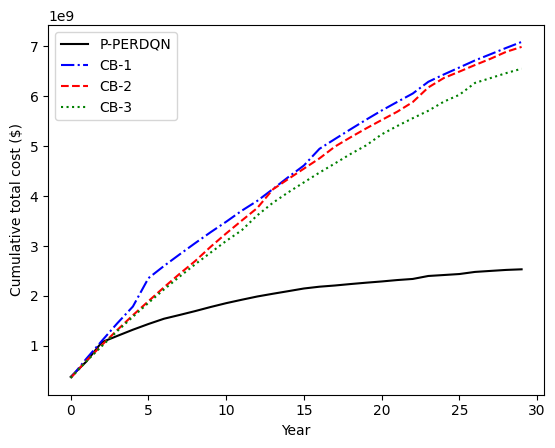

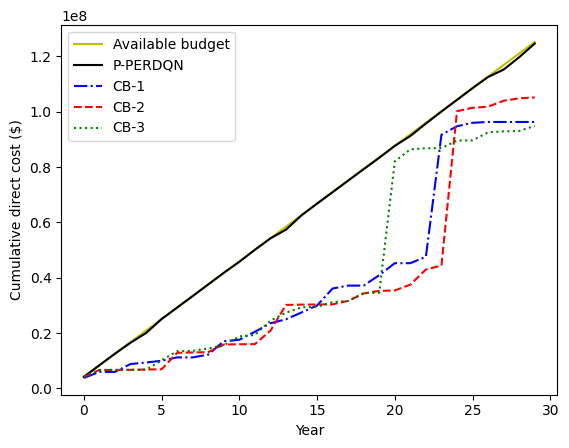

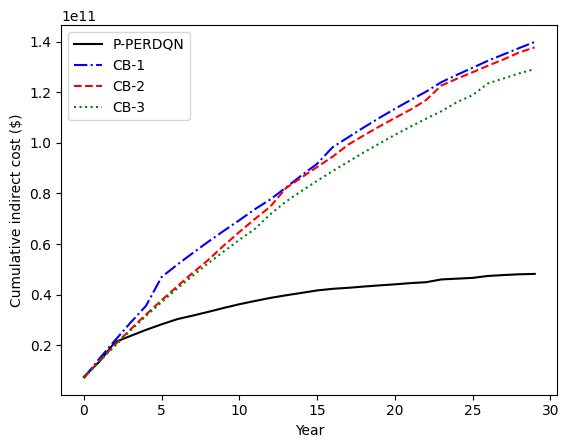

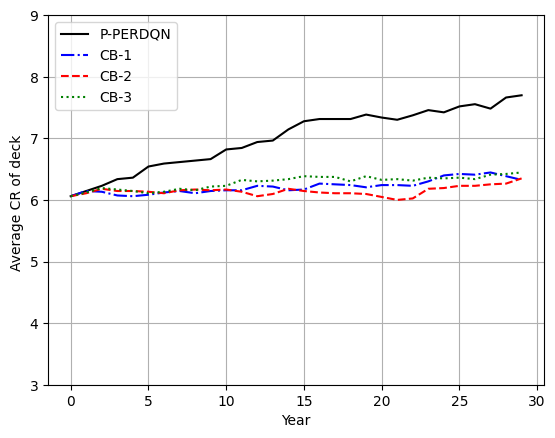

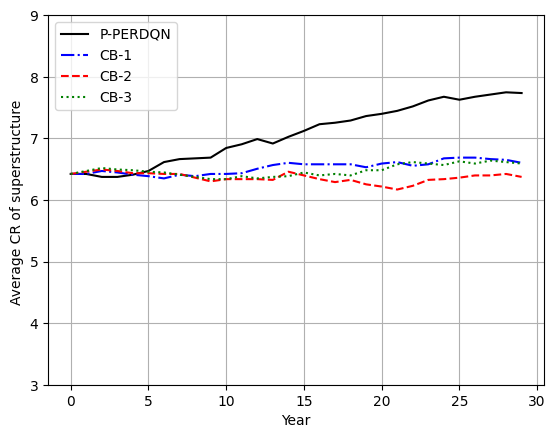

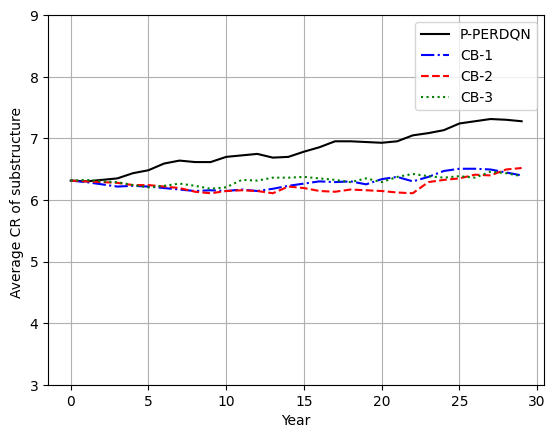

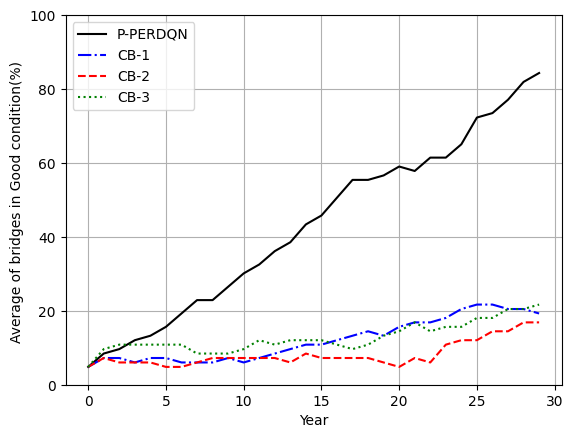

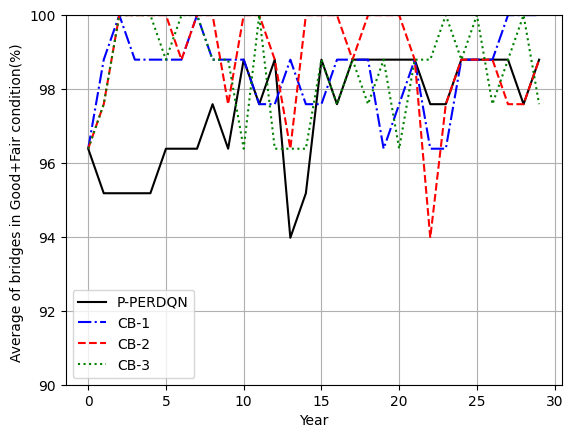

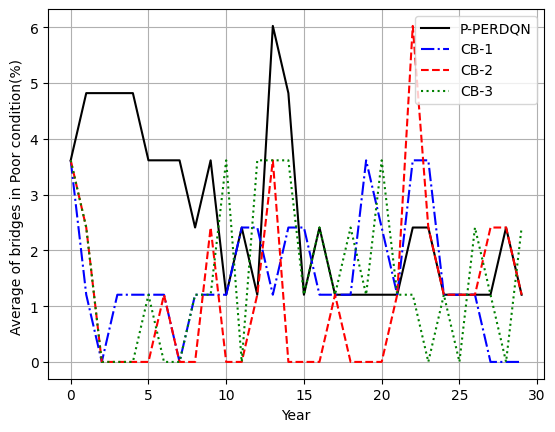

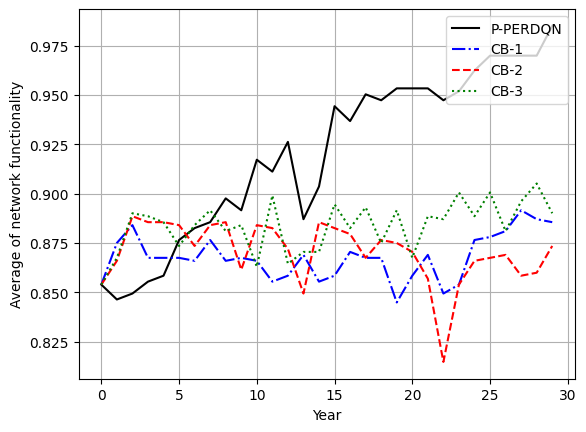

In [ ]:
########### Print results and compare policies ############################

####################### P-PERDQN ##############################################################
sum_deck = np.sum(deck_area_Net)
total_C_Bridge = sum_deck*C_b   # 10.764 convert from meter square to feet square
budget = total_C_Bridge * budget_ratio
print('Budget:', budget)
y_budget = np.ones(years)*budget
x = range(years)
reward_stat_PERDQN = -np.asarray(reward_stat)

direct_stat_PERDQN = np.asarray(direct_stat)

indirect_stat_PERDQN = np.asarray(indirect_stat)

states_stat_PERDQN = np.asarray(states_stat)

flow_stat_PERDQN = np.asarray(flow_stat)


####################### CB-1 ##############################################################
reward_stat_CB1 = -np.asarray(reward_stat_CB1)

direct_stat_CB1 = np.asarray(direct_stat_CB1)

indirect_stat_CB1 = np.asarray(indirect_stat_CB1)

states_stat_CB1 = np.asarray(states_stat_CB1)

flow_stat_CB1 = np.asarray(flow_stat_CB1)


####################### CB-2 ##############################################################

reward_stat_CB2 = -np.asarray(reward_stat_CB2)

direct_stat_CB2 = np.asarray(direct_stat_CB2)

indirect_stat_CB2 = np.asarray(indirect_stat_CB2)

states_stat_CB2 = np.asarray(states_stat_CB2)

flow_stat_CB2 = np.asarray(flow_stat_CB2)


####################### CB-3 ##############################################################

reward_stat_CB3 = -np.asarray(reward_stat_CB3)

direct_stat_CB3 = np.asarray(direct_stat_CB3)

indirect_stat_CB3 = np.asarray(indirect_stat_CB3)

states_stat_CB3 = np.asarray(states_stat_CB3)

flow_stat_CB3 = np.asarray(flow_stat_CB3)


#states_stat_PERDQN =states_stat_CB3
####################### post processing ##############################################################

x = range(years)
#PERDQN_NQ
y_reward_PERDQN_B = np.zeros(years)
y_direct_PERDQN_B = np.zeros(years)
y_indirect_PERDQN_B = np.zeros(years)

y_reward_PERDQN = np.zeros(years)
y_direct_PERDQN = np.zeros(years)
y_indirect_PERDQN = np.zeros(years)
y_state_deck_PERDQN = np.zeros(years)
y_state_super_PERDQN = np.zeros(years)
y_state_sub_PERDQN = np.zeros(years)
Good_PERDQN = np.zeros(years)
Fair_PERDQN = np.zeros(years)
Poor_PERDQN = np.zeros(years)

y_state_deck_PERDQN_B = np.zeros(years)
y_state_super_PERDQN_B = np.zeros(years)
y_state_sub_PERDQN_B = np.zeros(years)



y_reward_CB1 = np.zeros(years)
y_direct_CB1 = np.zeros(years)
y_indirect_CB1 = np.zeros(years)
y_state_deck_CB1 = np.zeros(years)
y_state_super_CB1 = np.zeros(years)
y_state_sub_CB1 = np.zeros(years)
Good_CB1 = np.zeros(years)
Fair_CB1 = np.zeros(years)
Poor_CB1 = np.zeros(years)

y_reward_CB2 = np.zeros(years)
y_direct_CB2 = np.zeros(years)
y_indirect_CB2 = np.zeros(years)
y_state_deck_CB2 = np.zeros(years)
y_state_super_CB2 = np.zeros(years)
y_state_sub_CB2 = np.zeros(years)
Good_CB2 = np.zeros(years)
Fair_CB2 = np.zeros(years)
Poor_CB2 = np.zeros(years)


y_reward_CB3_B = np.zeros(years)
y_direct_CB3_B = np.zeros(years)
y_indirect_CB3_B = np.zeros(years)

y_reward_CB3 = np.zeros(years)
y_direct_CB3 = np.zeros(years)
y_indirect_CB3 = np.zeros(years)
y_state_deck_CB3 = np.zeros(years)
y_state_super_CB3 = np.zeros(years)
y_state_sub_CB3 = np.zeros(years)
Good_CB3 = np.zeros(years)
Fair_CB3 = np.zeros(years)
Poor_CB3 = np.zeros(years)

def calculate_percentages(states_stat):
    # Get the minimum state for each bridge in each episode and each year
    min_states = np.min(states_stat, axis=-1)  # Shape: (num_episodes, num_bridge, years)

    # Calculate percentages for each category
    percent_good = np.mean((min_states >= 6) & (min_states <= 8), axis=1) * 100  # 8, 7, or 6
    percent_fair = np.mean((min_states == 5) | (min_states == 4), axis=1) * 100    # 5 or 4
    percent_poor = np.mean(min_states <= 3, axis=1) * 100                     # 3, 2, 1, or 0

    return percent_good, percent_fair, percent_poor



for i in range(years):
    y1_reward_PERDQN= np.sum(reward_stat_PERDQN[:, :, i], axis=1)
    y_reward_PERDQN[i] = np.mean(y1_reward_PERDQN)

    y1_direct_PERDQN= np.sum(direct_stat_PERDQN[:, :, i], axis=1)
    y_direct_PERDQN[i] = np.mean(y1_direct_PERDQN)

    y1_indirect_PERDQN= np.sum(indirect_stat_PERDQN[:, :, i], axis=1)
    y_indirect_PERDQN[i] = np.mean(y1_indirect_PERDQN)




    y_state_deck_PERDQN[i] = np.mean(states_stat_PERDQN[:,:,i,0])+1
    y_state_super_PERDQN[i] = np.mean(states_stat_PERDQN[:,:,i,1])+1
    y_state_sub_PERDQN[i] = np.mean(states_stat_PERDQN[:,:,i,2])+1




    percent_good_PERDQN, percent_fair_PERDQN, percent_poor_PERDQN = calculate_percentages(states_stat_PERDQN)
    Good_PERDQN[i]=np.mean(percent_good_PERDQN[:,i])
    Fair_PERDQN[i]=np.mean(percent_fair_PERDQN[:,i])
    Poor_PERDQN[i]=np.mean(percent_poor_PERDQN[:,i])
##################### CB-1 ###################################################
    y1_reward_CB1= np.sum(reward_stat_CB1[:, :, i], axis=1)
    y_reward_CB1[i] = np.mean(y1_reward_CB1)

    y1_direct_CB1= np.sum(direct_stat_CB1[:, :, i], axis=1)
    y_direct_CB1[i] = np.mean(y1_direct_CB1)

    y1_indirect_CB1= np.sum(indirect_stat_CB1[:, :, i], axis=1)
    y_indirect_CB1[i] = np.mean(y1_indirect_CB1)

    y_state_deck_CB1[i] = np.mean(states_stat_CB1[:,:,i,0])+1
    y_state_super_CB1[i] = np.mean(states_stat_CB1[:,:,i,1])+1
    y_state_sub_CB1[i] = np.mean(states_stat_CB1[:,:,i,2])+1

    percent_good_CB1, percent_fair_CB1, percent_poor_CB1 = calculate_percentages(states_stat_CB1)
    Good_CB1[i]=np.mean(percent_good_CB1[:,i])
    Fair_CB1[i]=np.mean(percent_fair_CB1[:,i])
    Poor_CB1[i]=np.mean(percent_poor_CB1[:,i])

##################### CB-2 ###################################################

    y1_reward_CB2= np.sum(reward_stat_CB2[:, :, i], axis=1)
    y_reward_CB2[i] = np.mean(y1_reward_CB2)

    y1_direct_CB2= np.sum(direct_stat_CB2[:, :, i], axis=1)
    y_direct_CB2[i] = np.mean(y1_direct_CB2)

    y1_indirect_CB2= np.sum(indirect_stat_CB2[:, :, i], axis=1)
    y_indirect_CB2[i] = np.mean(y1_indirect_CB2)

    y_state_deck_CB2[i] = np.mean(states_stat_CB2[:,:,i,0])+1
    y_state_super_CB2[i] = np.mean(states_stat_CB2[:,:,i,1])+1
    y_state_sub_CB2[i] = np.mean(states_stat_CB2[:,:,i,2])+1

    percent_good_CB2, percent_fai_CB2r, percent_poor_CB2 = calculate_percentages(states_stat_CB2)
    Good_CB2[i]=np.mean(percent_good_CB2[:,i])
    Fair_CB2[i]=np.mean(percent_fai_CB2r[:,i])
    Poor_CB2[i]=np.mean(percent_poor_CB2[:,i])
##################### CB-3 ###################################################

    y1_reward_CB3= np.sum(reward_stat_CB3[:, :, i], axis=1)
    y_reward_CB3[i] = np.mean(y1_reward_CB3)

    y1_direct_CB3= np.sum(direct_stat_CB3[:, :, i], axis=1)
    y_direct_CB3[i] = np.mean(y1_direct_CB3)

    y1_indirect_CB3= np.sum(indirect_stat_CB3[:, :, i], axis=1)
    y_indirect_CB3[i] = np.mean(y1_indirect_CB3)

    y_state_deck_CB3[i] = np.mean(states_stat_CB3[:,:,i,0])+1
    y_state_super_CB3[i] = np.mean(states_stat_CB3[:,:,i,1])+1
    y_state_sub_CB3[i] = np.mean(states_stat_CB3[:,:,i,2])+1

    percent_good_CB3, percent_fair_CB3, percent_poor_CB3 = calculate_percentages(states_stat_CB3)
    Good_CB3[i]=np.mean(percent_good_CB3[:,i])
    Fair_CB3[i]=np.mean(percent_fair_CB3[:,i])
    Poor_CB3[i]=np.mean(percent_poor_CB3[:,i])




plt.figure(1)
plt.plot(x,np.cumsum(y_reward_PERDQN),'k',x,np.cumsum(y_reward_CB1),'b-.',x,np.cumsum(y_reward_CB2),'r--',x,np.cumsum(y_reward_CB3),'g:')
plt.xlabel('Year')
plt.ylabel('Cumulative total cost ($)')
plt.legend(['P-PERDQN', 'CB-1', 'CB-2', 'CB-3'])

plt.figure(2)
plt.plot(x,np.cumsum(y_budget),'y',x,np.cumsum(y_direct_PERDQN),'k',x,np.cumsum(y_direct_CB1),'b-.',x,np.cumsum(y_direct_CB2),'r--',x,np.cumsum(y_direct_CB3),'g:')
plt.xlabel('Year')
plt.ylabel('Cumulative direct cost ($)')
plt.legend(['Available budget','P-PERDQN', 'CB-1', 'CB-2', 'CB-3'])


plt.figure(3)
plt.plot(x,np.cumsum(y_indirect_PERDQN),'k',x,np.cumsum(y_indirect_CB1),'b-.',x,np.cumsum(y_indirect_CB2),'r--',x,np.cumsum(y_indirect_CB3),'g:')
plt.xlabel('Year')
plt.ylabel('Cumulative indirect cost ($)')
plt.legend(['P-PERDQN', 'CB-1', 'CB-2', 'CB-3'])


plt.figure(4)
plt.plot(x,y_state_deck_PERDQN,'k',x,y_state_deck_CB1,'b-.',x,y_state_deck_CB2,'r--',x,y_state_deck_CB3,'g:')
plt.xlabel('Year')
plt.ylabel('Average CR of deck ')
plt.legend(['P-PERDQN', 'CB-1', 'CB-2', 'CB-3'])
plt.ylim([3,9])
plt.grid()


plt.figure(5)
plt.plot(x,y_state_super_PERDQN,'k',x,y_state_super_CB1,'b-.',x,y_state_super_CB2,'r--',x,y_state_super_CB3,'g:')
plt.xlabel('Year')
plt.ylabel('Average CR of superstructure ')
plt.legend(['P-PERDQN', 'CB-1', 'CB-2', 'CB-3'])
plt.ylim([3,9])
plt.grid()


plt.figure(6)
plt.plot(x,y_state_sub_PERDQN,'k',x,y_state_sub_CB1,'b-.',x,y_state_sub_CB2,'r--',x,y_state_sub_CB3,'g:')
plt.xlabel('Year')
plt.ylabel('Average CR of substructure ')
plt.legend(['P-PERDQN', 'CB-1', 'CB-2', 'CB-3'])
plt.ylim([3,9])
plt.grid()



plt.figure(7)
plt.plot(x,Good_PERDQN,'k',x,Good_CB1,'b-.',x,Good_CB2,'r--',x,Good_CB3,'g:')
plt.xlabel('Year')
plt.ylabel('Average of bridges in Good condition(%) ')
plt.legend(['P-PERDQN', 'CB-1', 'CB-2', 'CB-3'])
plt.ylim([0,100])
plt.grid()

plt.figure(8)
plt.plot(x,Good_PERDQN+Fair_PERDQN,'k',x,Fair_CB1+Good_CB1,'b-.',x,Fair_CB2+Good_CB2,'r--',x,Fair_CB3+Good_CB3,'g:')
plt.xlabel('Year')
plt.ylabel('Average of bridges in Good+Fair condition(%) ')
plt.legend(['P-PERDQN', 'CB-1', 'CB-2', 'CB-3'])
plt.ylim([90,100])
plt.grid()

plt.figure(9)
plt.plot(x,Poor_PERDQN,'k',x,Poor_CB1,'b-.',x,Poor_CB2,'r--',x,Poor_CB3,'g:')
plt.xlabel('Year')
plt.ylabel('Average of bridges in Poor condition(%) ')
plt.legend(['P-PERDQN', 'CB-1', 'CB-2', 'CB-3'])

plt.grid()

for xx in times:
    print(f"********************************************************************************")
    print(f"*********************************   year = {xx}  *******************************")
    print(f"********************************************************************************")

    print(f"###########################   P-PERDQN  ######################################")

    sum_values_reward_PERDQN = np.sum(reward_stat_PERDQN[:, :, xx], axis=1)
    avg_reward_PERDQN = np.mean(sum_values_reward_PERDQN)

    sum_values_direct_PERDQN = np.sum(direct_stat_PERDQN[:, :, xx], axis=1)
    avg_direct_PERDQN = np.mean(sum_values_direct_PERDQN)

    sum_values_indirect_PERDQN = np.sum(indirect_stat_PERDQN[:, :, xx], axis=1)
    avg_indirect_PERDQN = np.mean(sum_values_indirect_PERDQN)

    avg_state_deck_PERDQN = np.mean(states_stat_PERDQN[:,:,x,0])+1
    avg_state_super_PERDQN = np.mean(states_stat_PERDQN[:,:,x,1])+1
    avg_state_sub_PERDQN = np.mean(states_stat_PERDQN[:,:,x,2])+1
    print(f"##### total cost, year = {xx} #####", avg_reward_PERDQN)
    print(f"##### direct cost, year = {xx} #####", avg_direct_PERDQN)
    print(f"##### Indirect cost, year = {xx} #####", avg_indirect_PERDQN)
    print(f"##### CR Deck year = {xx} #####", avg_state_deck_PERDQN)
    print(f"##### CR Super year = {xx} #####", avg_state_super_PERDQN)
    print(f"##### CR Sub year = {xx} #####", avg_state_sub_PERDQN)

    print(f"###########################   CB-1  ######################################")
    sum_values_reward_CB1 = np.sum(reward_stat_CB1[:, :, xx], axis=1)
    avg_reward_CB1 = np.mean(sum_values_reward_CB1)

    sum_values_direct_CB1 = np.sum(direct_stat_CB1[:, :, xx], axis=1)
    avg_direct_CB1 = np.mean(sum_values_direct_CB1)

    sum_values_indirect_CB1 = np.sum(indirect_stat_CB1[:, :, xx], axis=1)
    avg_indirect_CB1 = np.mean(sum_values_indirect_CB1)

    avg_state_deck_CB1 = np.mean(states_stat_CB1[:,:,x,0])+1
    avg_state_super_CB1 = np.mean(states_stat_CB1[:,:,x,1])+1
    avg_state_sub_CB1 = np.mean(states_stat_CB1[:,:,x,2])+1
    print(f"##### total cost, year = {xx} #####", avg_reward_CB1)
    print(f"##### direct cost, year = {xx} #####", avg_direct_CB1)
    print(f"##### Indirect cost, year = {xx} #####", avg_indirect_CB1)
    print(f"##### CR Deck year = {xx} #####", avg_state_deck_CB1)
    print(f"##### CR Super year = {xx} #####", avg_state_super_CB1)
    print(f"##### CR Sub year = {xx} #####", avg_state_sub_CB1)

    print(f"###########################   CB-2  ######################################")
    sum_values_reward_CB2 = np.sum(reward_stat_CB2[:, :, xx], axis=1)
    avg_reward_CB2 = np.mean(sum_values_reward_CB2)

    sum_values_direct_CB2 = np.sum(direct_stat_CB2[:, :, xx], axis=1)
    avg_direct_CB2 = np.mean(sum_values_direct_CB2)

    sum_values_indirect_CB2 = np.sum(indirect_stat_CB2[:, :, xx], axis=1)
    avg_indirect_CB2 = np.mean(sum_values_indirect_CB2)

    avg_state_deck_CB2 = np.mean(states_stat_CB2[:,:,x,0])+1
    avg_state_super_CB2 = np.mean(states_stat_CB2[:,:,x,1])+1
    avg_state_sub_CB2 = np.mean(states_stat_CB2[:,:,x,2])+1
    print(f"##### total cost, year = {xx} #####", avg_reward_CB2)
    print(f"##### direct cost, year = {xx} #####", avg_direct_CB2)
    print(f"##### Indirect cost, year = {xx} #####", avg_indirect_CB2)
    print(f"##### CR Deck year = {xx} #####", avg_state_deck_CB2)
    print(f"##### CR Super year = {xx} #####", avg_state_super_CB2)
    print(f"##### CR Sub year = {xx} #####", avg_state_sub_CB2)

    print(f"###########################   CB-3  ######################################")
    sum_values_reward_CB3 = np.sum(reward_stat_CB3[:, :, xx], axis=1)
    avg_reward_CB3 = np.mean(sum_values_reward_CB3)

    sum_values_direct_CB3 = np.sum(direct_stat_CB3[:, :, xx], axis=1)
    avg_direct_CB3 = np.mean(sum_values_direct_CB3)

    sum_values_indirect_CB3 = np.sum(indirect_stat_CB3[:, :, xx], axis=1)
    avg_indirect_CB3 = np.mean(sum_values_indirect_CB3)

    avg_state_deck_CB3 = np.mean(states_stat_CB3[:,:,x,0])+1
    avg_state_super_CB3 = np.mean(states_stat_CB3[:,:,x,1])+1
    avg_state_sub_CB3 = np.mean(states_stat_CB3[:,:,x,2])+1
    print(f"##### total cost, year = {xx} #####", avg_reward_CB3)
    print(f"##### direct cost, year = {xx} #####", avg_direct_CB3)
    print(f"##### Indirect cost, year = {xx} #####", avg_indirect_CB3)
    print(f"##### CR Deck year = {xx} #####", avg_state_deck_CB3)
    print(f"##### CR Super year = {xx} #####", avg_state_super_CB3)
    print(f"##### CR Sub year = {xx} #####", avg_state_sub_CB3)


############################################################################################################
############################################################################################################


############################################################################################################
############################################################################################################
############################################################################################################




y2_flow_PERDQN = np.zeros(years)
y2_flow_CB1 = np.zeros(years)
y2_flow_CB2 = np.zeros(years)
y2_flow_CB3 = np.zeros(years)

aa_PERDQN = np.mean(flow_stat_PERDQN,axis=1)
aa_CB1 = np.mean(flow_stat_CB1,axis=1)
aa_CB2 = np.mean(flow_stat_CB2,axis=1)
aa_CB3 = np.mean(flow_stat_CB3,axis=1)


plt.figure(12)
plt.plot(x,np.mean(aa_PERDQN,axis=0),'k',x,np.mean(aa_CB1,axis=0),'b-.',x,np.mean(aa_CB2,axis=0),'r--',x,np.mean(aa_CB3,axis=0),'g:')
plt.xlabel('Year')
plt.ylabel('Average of network functionality')
plt.legend(['P-PERDQN', 'CB-1', 'CB-2', 'CB-3'],loc = "upper right")

plt.grid()



